# Tarefa 2-1: Redes Neurais Totalmente Conectadas

Antes de começar, coloque seu nome e RA no seguinte formato

: Nome SOBRENOME, #000000   //   e.g.) Jurandy ALMEIDA, #123456

**Sua Resposta:**   
Sergio JUNIOR, #801814

# Código de Configuração
Antes de começarmos, precisamos executar algum código padrão para configurar nosso ambiente. Você precisará executar novamente este código de configuração sempre que iniciar o notebook.

Primeiro, execute esta célula para carregar a extensão [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload). Isso nos permite editar arquivos de origem `.py` e reimportá-los para o notebook para uma experiência de edição e depuração perfeita.

In [1]:
%load_ext autoreload
%autoreload 2

### Configuração do Google Colab
Em seguida, precisamos executar alguns comandos para configurar nosso ambiente no Google Colab. Se você estiver executando este notebook em uma máquina local, pode pular esta seção.

Execute a seguinte célula para montar seu Google Drive. Siga o link, entre na sua conta do Google (a mesma conta que você usou para armazenar este notebook!) E copie o código de autorização na caixa de texto que aparece abaixo.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Agora lembre-se do caminho em seu Google Drive onde você carregou este notebook, preencha-o abaixo. Se tudo estiver funcionando corretamente, a execução da célula a seguir deve imprimir os nomes dos arquivos da tarefa:

```
['t2_auxiliares.py', 'redes_convolucionais.ipynb', 'redes_convolucionais.py', 'redes_totalmente_conectadas.ipynb', 'redes_totalmente_conectadas.py', 'pi']
```

In [5]:
import os

# TODO: Preencha o caminho do Google Drive para onde você carregou a tarefa
# Exemplo: se você criar uma pasta PI-2024-1 e colocar todos os arquivos na pasta T2, então 'PI-2024-1/T2'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'PI-2024-1/T2'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'PI-2024-1/T2'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['redes_convolucionais.py', 't2_auxiliares.py', 'redes_convolucionais.ipynb', 'pi', '__pycache__', 'redes_totalmente_conectadas.py', 'melhor_rede_duas_camadas.pt', 'melhor_sobreajuste_rede_cinco_camadas.pt', 'redes_totalmente_conectadas.ipynb']


Depois de montar com sucesso seu Google Drive e localizar o caminho para esta tarefa, execute a seguinte célula para permitir a importação dos arquivos `.py` desta tarefa. Se funcionar corretamente, deve imprimir a mensagem:

```
Olá do redes_totalmente_conectadas.py!
Olá do t2_auxiliares.py!
```

bem como a última hora de edição do arquivo `redes_totalmente_conectadas.py`.

In [6]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()

from redes_totalmente_conectadas import ola_redes_totalmente_conectadas
ola_redes_totalmente_conectadas()

from t2_auxiliares import ola_auxiliar
ola_auxiliar()

redes_totalmente_conectadas_path = os.path.join(GOOGLE_DRIVE_PATH, 'redes_totalmente_conectadas.py')
redes_totalmente_conectadas_edit_time = time.ctime(os.path.getmtime(redes_totalmente_conectadas_path))
print('redes_totalmente_conectadas.py última edição em %s' % redes_totalmente_conectadas_edit_time)

Olá do redes_totalmente_conectadas.py!
Olá do t2_auxiliares.py!
redes_totalmente_conectadas.py última edição em Tue Aug 20 13:20:27 2024


# Pré-processamento dos dados

## Códigos de configuração
Execute alguns códigos de configuração para este notebook: Importe alguns pacotes úteis e aumente o tamanho da figura padrão.

In [7]:
import pi
import torch
import torchvision
import matplotlib.pyplot as plt
import statistics
import random
import time
import math
%matplotlib inline

from pi import redefinir_semente, Solucionador

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

A partir desta tarefa, usaremos a GPU para acelerar nosso cálculo. Execute esta célula para certificar-se de que está usando uma GPU.

In [8]:
if torch.cuda.is_available:
  print('Pronto para continuar!')
else:
  print('Por favor, habilite a GPU em Edit -> Notebook Settings.')

Pronto para continuar!


## Carregue o conjunto de dados CIFAR-10
Em seguida, primeiro carregaremos o conjunto de dados CIFAR-10. A função de utilidade `pi.data.preprocessar_cifar10()` retorna o conjunto de dados CIFAR-10 como um conjunto de seis **tensores do Torch** enquanto também pré-processa as imagens RGB:

- `X_treino` contém todas as imagens de treino (números reais no intervalo $[0, 1]$)
- `y_treino` contém todos os rótulos de treino (inteiros no intervalo $[0, 9]$)
- `X_val` contém todas as imagens de validação
- `y_val` contém todos os rótulos de validação
- `X_teste` contém todas as imagens de teste
- `y_teste` contém todos os rótulos de teste

Podemos aprender mais sobre a função `pi.data.preprocessar_cifar10` invocando o comando` help`:

In [9]:
import pi
help(pi.data.preprocessar_cifar10)

Help on function preprocessar_cifar10 in module pi.data:

preprocessar_cifar10(cuda=True, exibir_amostras=True, truque_vies=False, achatado=True, taxa_validacao=0.2, dtype=torch.float32)
    Retorna uma versão pré-processada do conjunto de dados CIFAR10, automaticamente
    baixando se necessário. Realizamos as seguintes etapas:
    
    (0) [Opcional] Visualiza algumas imagens do conjunto de dados
    (1) Normaliza os dados subtraindo a média
    (2) [Opcional] Remodela cada imagem de forma (3, 32, 32) em um vetor de forma (3072,)
    (3) [Opcional] Truque do viés: adiciona uma dimensão extra de uns aos dados
    (4) Elabora um conjunto de validação do conjunto de treinamento
    
    Entrada:
    - cuda: se verdadeiro, move todo o conjunto de dados para a GPU
    - taxa_validacao: Real no intervalo (0, 1) indicando a fração do conjunto de 
      treinamento para reservar para validação
    - truque_vies: Booleano dizendo se deve ou não aplicar o truque do viés
    - achatado: Boolean

Agora podemos executar a função `pi.data.preprocess_cifar10` para obter nossos dados:

100%|██████████| 170498071/170498071 [00:05<00:00, 31114531.49it/s]


Extracting ./cifar-10-python.tar.gz to .


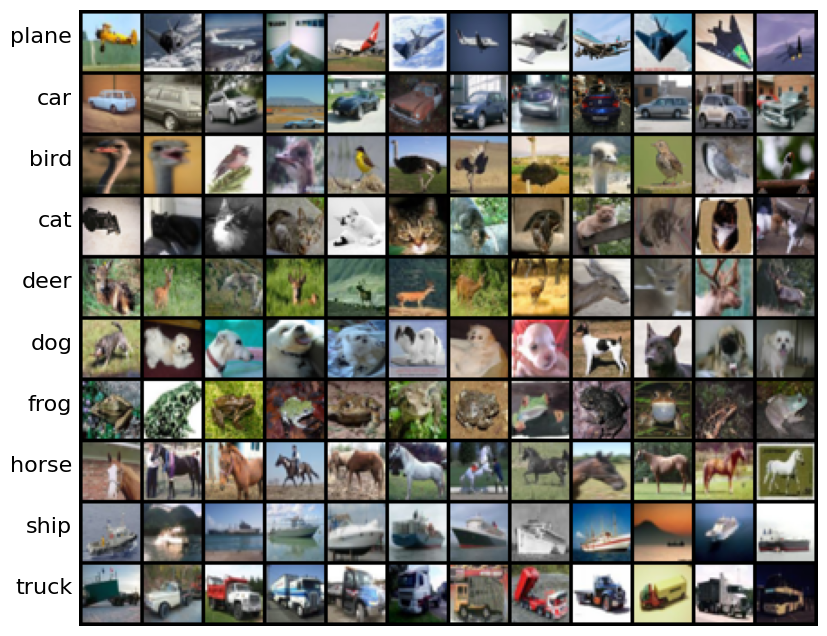

Dados de treinamento (shape):  torch.Size([40000, 3072])
Rótulos de treinamento (shape):  torch.Size([40000])
Dados de validação (shape):  torch.Size([10000, 3072])
Rótulos de valicação (shape):  torch.Size([10000])
Dados de teste (shape):  torch.Size([10000, 3072])
Rótulos de teste (shape):  torch.Size([10000])


In [10]:
# Chame a rotina acima para obter nossos dados.
import pi

redefinir_semente(0)
dic_dados = pi.data.preprocessar_cifar10(dtype=torch.float32)
print('Dados de treinamento (shape): ', dic_dados['X_treino'].shape)
print('Rótulos de treinamento (shape): ', dic_dados['y_treino'].shape)
print('Dados de validação (shape): ', dic_dados['X_val'].shape)
print('Rótulos de valicação (shape): ', dic_dados['y_val'].shape)
print('Dados de teste (shape): ', dic_dados['X_teste'].shape)
print('Rótulos de teste (shape): ', dic_dados['y_teste'].shape)

# Redes neurais totalmente conectadas
Neste exercício, iremos desenvolver uma rede neural com camadas totalmente conectadas para realizar a classificação e testá-la no conjunto de dados CIFAR-10.

Treinamos a rede com uma função de perda softmax e regularização L2 nas matrizes de peso. A rede usa uma não-linearidade ReLU após a primeira camada totalmente conectada.

Em outras palavras, a rede possui a seguinte arquitetura:

  entrada -  linear - ReLU - linear

As saídas da segunda camada totalmente conectada são as pontuações de cada classe.

## Definindo modelos em PyTorch
No PyTorch, um modelo é representado por uma classe do Python que herda da classe [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).
Os métodos mais fundamentais que é preciso implementar são:

- **\_\_init\_\_(self):** define as partes que constituem o modelo - no nosso caso, dois parâmetros, `W` e `b`. Você não está limitado a definir parâmetros, embora os modelos também podem conter outros modelos (ou camadas) como seus atributos, portanto, você pode aninhá-los facilmente. Veremos um exemplo disso a seguir.
- **forward(self, X)**: executa o cálculo real, ou seja, emite uma previsão, dada a entrada `X`. Entretanto, você **NÃO** deve chamar o método `forward(X)`. Você deve usar o nome da instância do modelo, por exemplo, `nome_instancia_do_modelo(X)`, para realizar uma passagem para frente e obter previsões de saída.


In [11]:
class Linear(torch.nn.Module):

  def __init__(self, tamanho_entrada, tamanho_saida,
               dtype=torch.float32, device='cuda', std=1e-4):
    """
    Inicializa o modelo. Pesos são inicializados com pequenos valores aleatórios
    e vieses são inicializados com zero.

    W: tensor `dtype` de shape (tamanho_entrada, tamanho_saida) contendo os pesos
    b: tensor `dtype` de shape (tamanho_saida,) contendo os vieses

    Entrada:
    - tamanho_entrada: A dimensão D dos dados de entrada.
    - tamanho_saida: O número de categorias C.
    - dtype: Opcional, tipo de dados de cada parâmetro de peso.
    - device: Opcional, se os parâmetros de peso estão na GPU ou CPU.
    - std: Opcional, ajuste de escala dos parâmetros de peso.
    """
    super().__init__()

    # redefine a semente antes de começar
    random.seed(0)
    torch.manual_seed(0)

    # Inicializa os parâmetros W e b com valores aleatórios
    self.W = torch.nn.Parameter(std * torch.randn(tamanho_entrada, tamanho_saida, requires_grad=True, dtype=dtype, device=device))
    self.b = torch.nn.Parameter(torch.zeros(tamanho_saida, requires_grad=True, dtype=dtype, device=device))

  def forward(self, X):
    """
    Executa o passo para frente da rede para calcular as saídas da camada oculta e
    pontuações de classe. A arquitetura da rede deve ser:

    camada linear (pontuações)

    Entrada:
    - X: Dados de entrada de shape (N, D). Cada X[i] é uma amostra de treinamento.

    Retorno:
    - pontuacoes: Tensor de shape (N, C) contendo as pontuações de classe para X
      para cada valor de entrada.
    """
    return torch.matmul(X, self.W) + self.b

No método `__init__`, definimos nossos dois parâmetros, `W` e `b`, usando a classe `torch.nn.Parameter()`, para dizer ao PyTorch que esses tensores devem ser considerados parâmetros do modelo do qual são atributos.
Por que devemos nos preocupar com isso? Ao fazer isso, podemos usar o método `parameters()` do nosso modelo para recuperar um iterador sobre todos os parâmetros do modelo, mesmo aqueles parâmetros de modelos aninhados, que podemos usar para alimentar o otimizador (em vez de construir uma lista de parâmetros nós mesmos!).
Além disso, podemos obter os valores atuais para todos os parâmetros usando o método `state_dict()` do nosso modelo.



In [12]:
# Instancia o modelo
modelo = Linear(4, 3)

# Itera sobre todos os parâmetros do modelo
for param in modelo.parameters():
  print(param)

# Dicionário todos os parâmetros do modelo
print(modelo.state_dict())

Parameter containing:
tensor([[-9.2466e-05, -4.2534e-05, -2.6438e-04],
        [ 1.4518e-05, -1.2087e-05, -5.7973e-05],
        [-6.2285e-05, -3.2839e-05, -1.0745e-04],
        [-3.6314e-05, -1.6711e-04,  2.2655e-04]], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([0., 0., 0.], device='cuda:0', requires_grad=True)
OrderedDict([('W', tensor([[-9.2466e-05, -4.2534e-05, -2.6438e-04],
        [ 1.4518e-05, -1.2087e-05, -5.7973e-05],
        [-6.2285e-05, -3.2839e-05, -1.0745e-04],
        [-3.6314e-05, -1.6711e-04,  2.2655e-04]], device='cuda:0')), ('b', tensor([0., 0., 0.], device='cuda:0'))])


## Modelos aninhados
Em nosso modelo, criamos manualmente os parâmetros `W` e `b`. Agora, vamos usar o modelo [`torch.nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) do PyTorch como um atributo nosso, criando assim um modelo aninhado.
Mesmo que este seja claramente um exemplo inventado, já que estamos basicamente envolvendo o modelo subjacente sem adicionar nada de útil (ou, em absoluto!), ele ilustra bem o conceito.
No método `__init__`, criamos um atributo que contém nosso modelo Linear aninhado.
No método `forward()`, chamamos o próprio modelo aninhado para realizar o encaminhamento (observe, não estamos chamando `self.linear.forward(x)`!).

In [13]:
class Linear(torch.nn.Module):

  def __init__(self, tamanho_entrada, tamanho_saida):
    """
    Inicializa o modelo. Em vez de nossos parâmetros personalizados,
    usamos uma camada torch.nn.Linear do PyTorch

    Entrada:
    - tamanho_entrada: A dimensão D dos dados de entrada.
    - tamanho_saida: O número de categorias C.
    """
    super().__init__()

    # Instanciamos uma camada torch.nn.Linear do PyTorch
    self.linear = torch.nn.Linear(tamanho_entrada, tamanho_saida)

  def forward(self, X):
    """
    Executa o passo para frente da rede para calcular as saídas da camada oculta e
    pontuações de classe. A arquitetura da rede deve ser:

    camada linear (pontuações)

    Entrada:
    - X: Dados de entrada de shape (N, D). Cada X[i] é uma amostra de treinamento.

    Retorno:
    - pontuacoes: Tensor de shape (N, C) contendo as pontuações de classe para X
      para cada valor de entrada.
    """
    # Agora, basta chamar para a camada torch.nn.Linear para fazer predições
    return self.linear(X)

Agora, se chamarmos o método `parameters()` deste modelo, o PyTorch irá descobrir os parâmetros de seus atributos de forma recursiva. Você pode tentar você mesmo usando algo como: `*torch.nn.Linear().parameters()` para obter uma lista de todos os parâmetros. Você também pode adicionar novos atributos do tipo `torch.nn.Linear` e, mesmo que não os use de forma alguma no método `forward`, eles ainda serão listados em `parameters()`.

In [14]:
# Instancia o modelo
modelo = Linear(4, 3)

# Itera sobre todos os parâmetros do modelo
for param in modelo.parameters():
  print(param)

# Dicionário todos os parâmetros do modelo
print(modelo.state_dict())

Parameter containing:
tensor([[-0.0037,  0.2682, -0.4115, -0.3680],
        [-0.1926,  0.1341, -0.0099,  0.3964],
        [-0.0444,  0.1323, -0.1511, -0.0983]], requires_grad=True)
Parameter containing:
tensor([-0.4777, -0.3311, -0.2061], requires_grad=True)
OrderedDict([('linear.weight', tensor([[-0.0037,  0.2682, -0.4115, -0.3680],
        [-0.1926,  0.1341, -0.0099,  0.3964],
        [-0.0444,  0.1323, -0.1511, -0.0983]])), ('linear.bias', tensor([-0.4777, -0.3311, -0.2061]))])


## Modelos sequenciais
Nosso modelo era bastante simples. Você pode estar pensando: “*por que se preocupar em construir uma classe para ele?!*” Bem, você tem razão. Para modelos simples, que usam camadas comuns, onde a saída de uma camada é alimentada sequencialmente como uma entrada para a próxima, podemos usar o modelo [`torch.nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential).
Em nosso caso, construiríamos um modelo `torch.nn.Sequential` com um único argumento, ou seja, um camada `torch.nn.Linear`. O modelo seria assim:

In [15]:
# Alternativamente, você pode usar um modelo torch.nn.Sequencial
modelo = torch.nn.Sequential(torch.nn.Linear(3, 4))

# Itera sobre todos os parâmetros do modelo
for param in modelo.parameters():
  print(param)

# Dicionário todos os parâmetros do modelo
print(modelo.state_dict())

Parameter containing:
tensor([[ 0.0214,  0.2282,  0.3464],
        [-0.3914, -0.2514,  0.2097],
        [ 0.4794, -0.1188,  0.4320],
        [-0.0931,  0.0611,  0.5228]], requires_grad=True)
Parameter containing:
tensor([-0.5356, -0.3635, -0.1462, -0.2251], requires_grad=True)
OrderedDict([('0.weight', tensor([[ 0.0214,  0.2282,  0.3464],
        [-0.3914, -0.2514,  0.2097],
        [ 0.4794, -0.1188,  0.4320],
        [-0.0931,  0.0611,  0.5228]])), ('0.bias', tensor([-0.5356, -0.3635, -0.1462, -0.2251]))])


## Rede de duas camadas
Agora que você sabe como definir modelos, implemente uma rede de duas camadas usando as classes modulares do PyTorch.

Conclua a implementação da classe `RedeDuasCamadas`. Essa classe servirá como um modelo para as outras redes que você implementará nesta tarefa, portanto, leia atentamente para ter certeza de entender a API.

Como prática, **NÃO** permitiremos o uso da  classe [`torch.nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) apenas neste momento (você pode usá-las no próximo exercício). Porém, para operações que não envolvem parâmetros treináveis (funções de ativação como ReLU, operações como maxpool), você pode usar o módulo [`torch.nn.functional`](https://pytorch.org/docs/stable/nn.functional.html).

Depois de terminar de implementar os métodos `__init__` e `forward` da classe `RedeDuasCamadas`, calcule as pontuações e compare com a resposta. A diferença entre elas deve ser menor que `1e-6`.

In [16]:
from redes_totalmente_conectadas import RedeDuasCamadas

redefinir_semente(0)
N, D, H, C = 3, 5, 50, 7
X = torch.randn(N, D, dtype=torch.float64, device='cuda')
y = torch.randint(C, size=(N,), dtype=torch.int64, device='cuda')

std = 1e-3
# SUA_VEZ: Implemente os métodos da classe RedeDuasCamadas
modelo = RedeDuasCamadas(
           dim_entrada=D,
           dim_oculta=H,
           num_classes=C,
           escala_peso=std,
           dtype=torch.float64,
           device='cuda'
         )

print('Testando a inicialização ... ')
W1_std = torch.abs(modelo.W1.std() - std)
b1 = modelo.b1
W2_std = torch.abs(modelo.W2.std() - std)
b2 = modelo.b2
assert W1_std < std / 10, 'Os pesos da primeira camada não parecem corretos'
assert torch.all(b1 == 0), 'Os vieses da primeira camada não parecem corretos'
assert W2_std < std / 10, 'Os pesos da segunda camada não parecem corretos'
assert torch.all(b2 == 0), 'Os vieses da segunda camada não parecem corretos'

print('Testando o passo para frente ... ')
state_dict = modelo.state_dict()
state_dict['W1'] = torch.linspace(-0.7, 0.3, steps=D * H, dtype=torch.float64, device='cuda').reshape(D, H)
state_dict['b1'] = torch.linspace(-0.1, 0.9, steps=H, dtype=torch.float64, device='cuda')
state_dict['W2'] = torch.linspace(-0.3, 0.4, steps=H * C, dtype=torch.float64, device='cuda').reshape(H, C)
state_dict['b2'] = torch.linspace(-0.9, 0.1, steps=C, dtype=torch.float64, device='cuda')
modelo.load_state_dict(state_dict)
X = torch.linspace(-5.5, 4.5, steps=N * D, dtype=torch.float64, device='cuda').reshape(D, N).t()
pontuacoes = modelo(X)
print('Suas pontuacoes:')
print(pontuacoes)
print()
print('pontuacoes corretas:')
pontuacoes_corretas = torch.tensor(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]],
    dtype=torch.float64, device='cuda')
print(pontuacoes_corretas)
print()

# A diferença deve ser muito pequena. Conseguimos < 1e-6
pontuacoes_dif = (pontuacoes - pontuacoes_corretas).abs().sum().item()
print('Diferença entre suas pontuações e as pontuações corretas: %.2e' % pontuacoes_dif)

Testando a inicialização ... 
Testando o passo para frente ... 
Suas pontuacoes:
tensor([[11.5317, 12.2917, 13.0518, 13.8119, 14.5720, 15.3321, 16.0922],
        [12.0577, 12.7461, 13.4346, 14.1230, 14.8115, 15.4999, 16.1884],
        [12.5837, 13.2005, 13.8174, 14.4342, 15.0510, 15.6678, 16.2846]],
       device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)

pontuacoes corretas:
tensor([[11.5317, 12.2917, 13.0518, 13.8119, 14.5720, 15.3321, 16.0922],
        [12.0577, 12.7461, 13.4346, 14.1230, 14.8115, 15.4999, 16.1884],
        [12.5837, 13.2005, 13.8174, 14.4342, 15.0510, 15.6678, 16.2846]],
       device='cuda:0', dtype=torch.float64)

Diferença entre suas pontuações e as pontuações corretas: 5.12e-08


**IMPORTANTE:** é preciso colocar o modelo no mesmo dispositivo onde estão os dados. Se os dados forem tensores que residem na GPU, então o modelo também deve ser colocado dentro da GPU.

# Cálculo da perda

Agora, vamos abordar o cálculo da perda. Implemente a rotina `perda_softmax` para calcular a perda softmax.

Para verificar sua implementação, vamos executar o seguinte: calculamos a perda de dados de exemplo e comparamos com a resposta calculada por nossa implementação. A diferença entre a perda correta e a calculada deve ser menor que `1e-10`.

In [17]:
from redes_totalmente_conectadas import perda_softmax

y = torch.tensor([0, 5, 1])
# SUA_VEZ: Implemente a parte de cálculo de perda
perda = perda_softmax(pontuacoes, y)
print('Sua perda: ', perda.item())
perda_correta = 3.4702243556
print('Perda correta: ', perda_correta)
dif = (perda_correta - perda).item()

# deve ser muito pequena, conseguimos < 1e-10
print('Diferença: %.4e' % dif)

Sua perda:  3.4702243555953896
Perda correta:  3.4702243556
Diferença: 4.6105e-12


Depois de fazer isso, usaremos a verificação de gradiente numérico para ver se o gradiente analítico calculado por nosso passo para trás corresponde a um gradiente numérico.

Usaremos as funções `pi.grad.calcular_gradiente_numerico` e `pi.grad.erro_rel` para ajudar na verificação do gradiente numérico. Podemos aprender mais sobre essas funções usando o comando `help`:

In [18]:
help(pi.grad.calcular_gradiente_numerico)
print('-' * 80)
help(pi.grad.erro_rel)

Help on function calcular_gradiente_numerico in module pi.grad:

calcular_gradiente_numerico(f, x, h=1e-07)
    Calcula o gradiente numérico de f em x usando uma aproximação de 
    diferenças finitas. Usamos a diferença centrada:
    
    df    f(x + h) - f(x - h)
    -- ~= -------------------
    dx           2 * h
    
    Entrada:
    - f: Uma função que recebe a um tensor do torch e retorna um escalar do torch 
    - x: Um tensor do torch contendo o ponto no qual calcular o gradiente numérico
    - h: epsilon usado no cálculo da diferença finita
    
    Retorno:
    - grad: Um tensor de mesmo shape que x contendo o gradiente de f em x

--------------------------------------------------------------------------------
Help on function erro_rel in module pi.grad:

erro_rel(x, y, eps=1e-10)
    Calcula o erro relativo entre um par de tensores x e y,
    que é definido como:
    
                           max_i |x_i - y_i]|
    erro_rel(x, y) = -------------------------------
        

Execute o seguinte para realizar a verificação de gradiente numérico da sua função de perda softmax. Você deve ver erros relativos menores que `1e-6`.

In [19]:
from redes_totalmente_conectadas import perda_softmax

redefinir_semente(0)
num_classes, num_entradas = 10, 50
x = 0.001 * torch.randn(num_entradas, num_classes, requires_grad=True, dtype=torch.float64, device='cuda')
y = torch.randint(num_classes, size=(num_entradas,), dtype=torch.int64, device='cuda')

dx_num = pi.grad.calcular_gradiente_numerico(lambda x: perda_softmax(x, y), x)

x.retain_grad() # registra o histórico de operações aplicadas em x e define fórmulas para derivá-las.
perda = perda_softmax(x, y)
perda.backward() # calcula o gradiente da perda com relação a x
dx = x.grad

# Testa a função perda_softmax. A perda deve ser próxima a 2.3 e o erro dx deve ser em torno de 1e-7
print('\nTestando perda_softmax:')
print('perda: ', perda.item())
print('erro dx: ', pi.grad.erro_rel(dx_num, dx))


Testando perda_softmax:
perda:  2.3026286102347924
erro dx:  1.0417990900961368e-07


Como esperado, PyTorch pode nos ajudar novamente. No módulo [`torch.nn`](https://pytorch.org/docs/stable/nn.html#loss-functions) existem muitas funções de perda para você escolher, dependendo da tarefa em questão. Como o nosso caso é um problema de classificação, usaremos a perda softmax, a qual está implementada na classe [`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss).

In [20]:
# Instancia a função de perda
perda_softmax = torch.nn.CrossEntropyLoss()

# Calcula a perda
y = torch.tensor([0, 5, 1], device=pontuacoes.device)
perda = perda_softmax(pontuacoes, y)
print('Sua perda: ', perda.item())
perda_correta = 3.4702243556
print('Perda correta: ', perda_correta)
dif = (perda_correta - perda).item()

# deve ser muito pequena, conseguimos < 1e-10
print('Diferença: %.4e' % dif)

Sua perda:  3.470224355595389
Perda correta:  3.4702243556
Diferença: 4.6110e-12


Observe que `torch.nn.CrossEntropyLoss` na verdade cria uma instância da classe que calcula a função de perda - **NÃO** é a própria função de perda. O PyTorch torna muito fácil estender isso e escrever sua própria função de perda personalizada.

# Otimizador
Para treinar modelos, o PyTorch oferece o módulo [`torch.optim`](https://pytorch.org/docs/master/optim.html), o qual disponibiliza uma variedade de otimizadores.

Um otimizador pega os parâmetros que queremos atualizar - retornados pelo  método `parameters()` do modelo, a taxa de aprendizagem `lr` (do inglês, *learning rate*) e o coeficiente de regularização `weight_decay` que queremos usar (e possivelmente muitos outros hiperparâmetros também!) e executa as atualizações por meio de seu método `step()`. Depois disso, não é preciso zerar os gradientes um por um. Apenas chamamos o método `zero_grad()` do otimizador e pronto!

No código abaixo, criamos um otimizador [SGD](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) (do inglês, *stochastic gradient descent*) para atualizar os parâmetros `W1`, `b1`, `W2` e `b2` da nossa `RedeDuasCamadas`.

In [21]:
taxa_aprendizagem = 1.0
reg = 0.001

# Define um otimizador SGD para atualizar os parâmetros
otimizador = torch.optim.SGD(modelo.parameters(), lr=taxa_aprendizagem, weight_decay=reg)

# Treinando a rede
Vamos começar dando uma olhada em como é o coração do nosso algoritmo de treinamento. As cinco linhas abaixo passam um lote de entrada pelo modelo, calculam a perda, realizam a retropropagação e atualizam os parâmetros.

```python
pontuacoes = modelo(dados)                    # calcula a saída do modelo
perda = funcao_de_perda(pontuacoes, rotulos)  # calcula a perda

otimizador.zero_grad()  # limpa os gradientes anteriores
perda.backward()        # calcula o gradiente de todos os parâmetros com relação a perda

otimizador.step()       # atualiza o modelo usando o gradiente calculado
```
Cada uma das variáveis `dados`, `rotulos`, `pontuacoes` e `perda` é um tensor do PyTorch e permite que as derivadas sejam calculadas automaticamente.

Qualquer código que escrevermos é construído em torno disso - a especificação exata do modelo, como buscar um lote de dados e rótulos, cálculo da perda e os detalhes do otimizador. Nas células anteriores, já vimos como escrever um modelo simples em PyTorch, calcular a perda e definir um otimizador.

Agora é hora usá-los para treinar um classificador em um conjunto de dados real.

In [22]:
from redes_totalmente_conectadas import perda_softmax
from redes_totalmente_conectadas import RedeDuasCamadas

dim_entrada = 3 * 32 * 32
dim_oculta = 36
num_classes = 10
num_epocas = 20
taxa_aprendizagem = 1e-2
reg = 0.25

# Ajusta a semente aleatória antes de gerar um conjunto de parâmetros
redefinir_semente(0)
modelo = RedeDuasCamadas(dim_entrada, dim_oculta, num_classes, dtype=dic_dados['X_treino'].dtype, device=dic_dados['X_treino'].device)

# Define a função de perda
funcao_de_perda = perda_softmax

# Define um otimizador SGD para atualizar os parâmetros
otimizador = torch.optim.SGD(modelo.parameters(), lr=taxa_aprendizagem, weight_decay=reg)

# para cada época
for epoca in range(num_epocas):
  # O que é isso?!?
  modelo.train()

  pontuacoes = modelo(dic_dados['X_treino'])                  # calcula a saída do modelo
  perda = funcao_de_perda(pontuacoes, dic_dados['y_treino'])  # calcula a perda

  otimizador.zero_grad()  # limpa os gradientes anteriores
  perda.backward()        # calcula o gradiente de todos os parâmetros com relação a perda

  otimizador.step()       # atualiza o modelo usando o gradiente calculado

  print('epoca %d / %d: perda %f' % (epoca, num_epocas, perda))

epoca 0 / 20: perda 2.302587
epoca 1 / 20: perda 2.302586
epoca 2 / 20: perda 2.302586
epoca 3 / 20: perda 2.302586
epoca 4 / 20: perda 2.302585
epoca 5 / 20: perda 2.302585
epoca 6 / 20: perda 2.302585
epoca 7 / 20: perda 2.302584
epoca 8 / 20: perda 2.302584
epoca 9 / 20: perda 2.302584
epoca 10 / 20: perda 2.302584
epoca 11 / 20: perda 2.302583
epoca 12 / 20: perda 2.302583
epoca 13 / 20: perda 2.302583
epoca 14 / 20: perda 2.302583
epoca 15 / 20: perda 2.302583
epoca 16 / 20: perda 2.302582
epoca 17 / 20: perda 2.302582
epoca 18 / 20: perda 2.302582
epoca 19 / 20: perda 2.302582


Espero que você tenha notado uma instrução específica no código, à qual atribuí um comentário “*O que é isso?!?*” - `modelo.train()`.
No PyTorch, os modelos têm um método `train()` que, de forma um tanto decepcionante, **NÃO** executa uma etapa de treinamento. Seu único propósito é definir o modelo para o modo de treinamento. Por que isso é importante? Alguns modelos podem utilizar mecanismos como o Descarte (do inglês, *Dropout*), por exemplo, que apresentam comportamentos distintos nas fases de treinamento e inferência.


Até agora, definimos um otimizador, uma função de perda e um modelo. Olhe novamente o código dentro do laço de treinamento. Ele mudaria se estivéssemos usando um otimizador, ou uma função de perda, ou mesmo um modelo diferente? Se não, como podemos torná-lo mais genérico?
Bem, acho que poderíamos dizer que todas essas linhas de código realizam um passo de treinamento, fornecidos esses três elementos (otimizador, perda e modelo), os dados e os rótulos.
Então, que tal escrever uma função que recebe esses três elementos e retorna outra função que realiza um passo de treinamento, tomando um conjunto de dados e rótulos como argumentos e retornando as pontuações e a perda correspondente?
Então, podemos usar esta função de propósito geral para construir uma função `passo_de_treinamento()` a ser chamada dentro de nosso laço de treinamento.

In [23]:
def criar_passo_de_treinamento(modelo, funcao_de_perda, otimizador):
  # Cria a função que executa um passo no laço de treinamento
  def passo_de_treinamento(dados, rotulos):
    # Configura o modelo para o modo de treinamento
    modelo.train()

    pontuacoes = modelo(dados)                    # calcula a saída do modelo
    perda = funcao_de_perda(pontuacoes, rotulos)  # calcula a perda

    otimizador.zero_grad()  # limpa os gradientes anteriores
    perda.backward()        # calcula o gradiente de todos os parâmetros com relação a perda

    otimizador.step()       # atualiza o modelo usando o gradiente calculado

    # Retorna a perda
    return pontuacoes, perda.item()

  # Retorna a função que será chamada dentro do laço de treinamento
  return passo_de_treinamento

Agora nosso código deve ser parecido com isto. Veja como o laço de treinamento é minúsculo agora!

In [24]:
from redes_totalmente_conectadas import perda_softmax
from redes_totalmente_conectadas import RedeDuasCamadas

dim_entrada = 3 * 32 * 32
dim_oculta = 36
num_classes = 10
num_epocas = 20
taxa_aprendizagem = 1e-2
reg = 0.25

# Ajusta a semente aleatória antes de gerar um conjunto de parâmetros
redefinir_semente(0)
modelo = RedeDuasCamadas(dim_entrada, dim_oculta, num_classes, dtype=dic_dados['X_treino'].dtype, device=dic_dados['X_treino'].device)

# Define a função de perda
funcao_de_perda = perda_softmax

# Define um otimizador SGD para atualizar os parâmetros
otimizador = torch.optim.SGD(modelo.parameters(), lr=taxa_aprendizagem, weight_decay=reg)

# Cria a função que realiza o passo de treinamento para nosso modelo, função de perda e otimizador
passo_de_treinamento = criar_passo_de_treinamento(modelo, funcao_de_perda, otimizador)

# para cada época
for epoca in range(num_epocas):
  # Executa um passo do treinamento e retorna a perda correspondente
  pontuacoes, perda = passo_de_treinamento(dic_dados['X_treino'], dic_dados['y_treino'])
  print('epoca %d / %d: perda %f' % (epoca, num_epocas, perda))

epoca 0 / 20: perda 2.302587
epoca 1 / 20: perda 2.302586
epoca 2 / 20: perda 2.302586
epoca 3 / 20: perda 2.302586
epoca 4 / 20: perda 2.302585
epoca 5 / 20: perda 2.302585
epoca 6 / 20: perda 2.302585
epoca 7 / 20: perda 2.302584
epoca 8 / 20: perda 2.302584
epoca 9 / 20: perda 2.302584
epoca 10 / 20: perda 2.302584
epoca 11 / 20: perda 2.302583
epoca 12 / 20: perda 2.302583
epoca 13 / 20: perda 2.302583
epoca 14 / 20: perda 2.302583
epoca 15 / 20: perda 2.302583
epoca 16 / 20: perda 2.302582
epoca 17 / 20: perda 2.302582
epoca 18 / 20: perda 2.302582
epoca 19 / 20: perda 2.302582


# Carregador de dados
Vamos dar um descanso ao laço de treinamento e focar nos dados por um tempo. Até agora, simplesmente usamos tensores do PyTorch. Mas é possível fazer melhor construindo um conjunto de dados do PyTorch.

## Criando de um conjunto de dados

No PyTorch, um conjunto de dados é representado por uma classe do Python que herda da classe [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset), que é uma classe abstrata que representa um conjunto de dados. Você pode pensar nela como uma espécie de lista de tuplas do Python, cada tupla correspondendo a uma amostra (imagem, rótulo).

Os métodos mais fundamentais que é preciso implementar são:

- **\_\_init\_\_(self)**: leva todos os argumentos necessários para construir uma lista de tuplas - pode ser o nome de um arquivo CSV que será carregado e processado; pode ser dois tensores, um para imagens, outro para rótulos; ou qualquer outra coisa, dependendo da tarefa em questão. Não há necessidade de carregar todo o conjunto de dados neste método. Se o seu conjunto de dados for grande (por exemplo, dezenas de milhares de arquivos de imagem), carregá-lo de uma vez não seria eficiente em termos de memória. Nesse caso, recomenda-se carregá-los sob demanda (sempre que `__getitem__` for chamado).
- **\_\_getitem\_\_(self, index)**: permite que o conjunto de dados seja indexado, para que possa funcionar como uma lista e, dessa forma, possa suportar a indexação usando `conjunto_de_dados[i]` para obter o $i$-ésimo elemento, que deve retornar uma tupla (imagem, rótulo) correspondente à imagem solicitada. Podemos retornar as parcelas correspondentes de nosso conjunto de dados ou tensores pré-carregados ou, como mencionado acima, carregá-los sob demanda (como neste exemplo).
- **\_\_len\_\_(self)**: deve simplesmente retornar o tamanho de todo o conjunto de dados para que `len(conjunto_de_dados)` retorne o tamanho do conjunto de dados e, assim, sempre que for amostrado, sua indexação seja limitada ao tamanho real.

Como primeiro passo, vamos construir um carregador para o conjunto de dados CIFAR-10. Implemente os métodos `__init__`, `__len__` e o `__getitem__` da classe `ConjuntoDeDados`. Vamos construir um conjunto de dados personalizado simples que leva dois tensores como argumentos: um para os dados, um para os rótulos. Para qualquer índice fornecido, nossa classe de conjunto de dados retornará a parcela correspondente de cada um desses tensores.

In [25]:
from redes_totalmente_conectadas import ConjuntoDeDados

# SUA_VEZ: Implemente os métodos da classe ConjuntoDeDados
dados_de_treinamento = ConjuntoDeDados(dic_dados['X_treino'], dic_dados['y_treino'])
dados_de_validacao = ConjuntoDeDados(dic_dados['X_val'], dic_dados['y_val'])
dados_de_teste = ConjuntoDeDados(dic_dados['X_teste'], dic_dados['y_teste'])

# Verifica o método __len__
print('len(dados_de_treinamento) está correto: ', len(dados_de_treinamento) == 40000)
print('len(dados_de_validação) está correto: ', len(dados_de_validacao) == 10000)
print('len(dados_de_teste) está correto: ', len(dados_de_teste) == 10000)

# Verifica o método __getitem__
for i in range(0, 10000, 1000):
  imagem, rotulo = dados_de_treinamento[i]
  correto = imagem.size(0) == 3072 and imagem.dtype == torch.float32 and rotulo.dtype == torch.int64
  print('dados_de_treinamento[%d] está correto: ' % i, correto)

len(dados_de_treinamento) está correto:  True
len(dados_de_validação) está correto:  True
len(dados_de_teste) está correto:  True
dados_de_treinamento[0] está correto:  True
dados_de_treinamento[1000] está correto:  True
dados_de_treinamento[2000] está correto:  True
dados_de_treinamento[3000] está correto:  True
dados_de_treinamento[4000] está correto:  True
dados_de_treinamento[5000] está correto:  True
dados_de_treinamento[6000] está correto:  True
dados_de_treinamento[7000] está correto:  True
dados_de_treinamento[8000] está correto:  True
dados_de_treinamento[9000] está correto:  True


Você pode estar pensando "*por que ter todo esse trabalho para envolver alguns tensores em uma aula?*" E você tem razão: se um conjunto de dados nada mais é do que alguns tensores, podemos usar a classe [`torch.utils.data.TensorDataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset) do PyTorch, que fará praticamente o que fizemos em nosso conjunto de dados personalizado acima.

Você percebeu que construímos tensores de nosso conjunto de treinamento, mas não os enviamos para um dispositivo? Então, eles são tensores da CPU agora! Por que?
Não queremos que todos os nossos dados de treinamento sejam carregados em tensores de GPU, porque isso ocupa espaço na RAM da nossa preciosa placa de vídeo.

Então, novamente, por que estamos criando um conjunto de dados? Estamos fazendo isso porque queremos usar um **carregador de lotes de dados**.

## Carregando lotes de dados

Até agora, usamos todos os dados de treinamento em cada passo de treinamento. Dessa forma, aplicamos uma descida de gradiente nos dados como um todo. Isso é bom para um conjunto de dados ridiculamente pequeno, com certeza, mas se quisermos levar tudo isso a sério, devemos usar a descida de gradiente em minilote.

Portanto, precisamos dividir nosso conjunto de dados em minilotes. No Pytorch, a classe [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) é usada para esse trabalho. Para isso, dizemos qual conjunto de dados usar (aquele que acabamos de construir na seção anterior), o tamanho do minilote desejado e se queremos embaralhá-lo ou não.

Uma instância da classe `torch.utils.data.DataLoader` fornece um iterador que obtém um objeto `torch.utils.data.Dataset` e executa embaralhamento e carregamento dos dados em lotes. Isso é crucial quando as imagens são grandes e demoram para carregar. Nesse caso, a GPU pode ser deixada ociosa enquanto a CPU busca as imagens. Em contraste, a classe `torch.utils.data.DataLoader` (usando multiprocessamento) busca os dados de forma assíncrona e pré-busca os lotes a serem enviados à GPU. Inicializar o carregador de lotes de dados é muito fácil:

In [26]:
tamanho_lote=1000

# Define um carregador de lotes para os conjuntos de dados
lotes_de_treinamento = torch.utils.data.DataLoader(dataset=dados_de_treinamento, batch_size=tamanho_lote, shuffle=True)
lotes_de_validacao = torch.utils.data.DataLoader(dataset=dados_de_validacao, batch_size=tamanho_lote, shuffle=False)
lotes_de_teste = torch.utils.data.DataLoader(dataset=dados_de_teste, batch_size=tamanho_lote, shuffle=False)

Para recuperar um minilote de amostra, pode-se simplesmente executar o comando abaixo - ele retornará uma lista contendo dois tensores, um para os dados, outro para os rótulos.

In [27]:
next(iter(lotes_de_treinamento))

[tensor([[ 0.3635,  0.3321,  0.3204,  ..., -0.0073,  0.1064,  0.3339],
         [-0.1110, -0.2875, -0.2718,  ...,  0.4672,  0.4123,  0.3692],
         [-0.3738, -0.2051, -0.0914,  ..., -0.3642, -0.2505, -0.0112],
         ...,
         [ 0.4027,  0.3517,  0.3596,  ...,  0.5103,  0.5339,  0.5456],
         [ 0.4380,  0.4223,  0.4262,  ...,  0.0829,  0.1025,  0.1299],
         [-0.4012, -0.3894, -0.4051,  ..., -0.4308, -0.4034, -0.3995]],
        device='cuda:0'),
 tensor([5, 2, 1, 2, 3, 6, 0, 4, 8, 1, 7, 6, 0, 0, 3, 6, 8, 3, 2, 2, 0, 4, 8, 8,
         3, 2, 9, 3, 0, 3, 1, 9, 2, 2, 3, 4, 1, 6, 2, 8, 1, 4, 4, 6, 7, 0, 6, 0,
         6, 6, 9, 5, 9, 5, 0, 9, 9, 2, 6, 0, 9, 6, 0, 9, 3, 5, 1, 6, 1, 7, 2, 8,
         0, 0, 2, 0, 5, 6, 6, 1, 1, 1, 1, 3, 6, 8, 8, 5, 3, 7, 1, 3, 1, 6, 2, 1,
         2, 2, 2, 6, 3, 7, 8, 7, 3, 8, 7, 2, 7, 2, 1, 9, 1, 6, 9, 2, 6, 8, 1, 8,
         1, 4, 5, 0, 7, 8, 1, 9, 2, 9, 2, 2, 3, 8, 2, 6, 6, 7, 1, 2, 7, 0, 8, 8,
         7, 2, 3, 0, 9, 7, 6, 8, 1, 4, 3, 7, 6,

Podemos então iterar sobre lotes de dados da seguinte maneira:

In [28]:
for i, (lote_dados, lote_rotulos) in enumerate(lotes_de_treinamento):
    print('lote: %d' % i, \
          ' - lote_dados(shape):', lote_dados.shape, \
          ' - lote_rotulos(shape):', lote_rotulos.shape)

lote: 0  - lote_dados(shape): torch.Size([1000, 3072])  - lote_rotulos(shape): torch.Size([1000])
lote: 1  - lote_dados(shape): torch.Size([1000, 3072])  - lote_rotulos(shape): torch.Size([1000])
lote: 2  - lote_dados(shape): torch.Size([1000, 3072])  - lote_rotulos(shape): torch.Size([1000])
lote: 3  - lote_dados(shape): torch.Size([1000, 3072])  - lote_rotulos(shape): torch.Size([1000])
lote: 4  - lote_dados(shape): torch.Size([1000, 3072])  - lote_rotulos(shape): torch.Size([1000])
lote: 5  - lote_dados(shape): torch.Size([1000, 3072])  - lote_rotulos(shape): torch.Size([1000])
lote: 6  - lote_dados(shape): torch.Size([1000, 3072])  - lote_rotulos(shape): torch.Size([1000])
lote: 7  - lote_dados(shape): torch.Size([1000, 3072])  - lote_rotulos(shape): torch.Size([1000])
lote: 8  - lote_dados(shape): torch.Size([1000, 3072])  - lote_rotulos(shape): torch.Size([1000])
lote: 9  - lote_dados(shape): torch.Size([1000, 3072])  - lote_rotulos(shape): torch.Size([1000])
lote: 10  - lote_dad

Como isso muda o laço de treinamento? Vamos dar uma olhada!

In [29]:
from redes_totalmente_conectadas import perda_softmax
from redes_totalmente_conectadas import RedeDuasCamadas

dim_entrada = 3 * 32 * 32
dim_oculta = 36
num_classes = 10
num_epocas = 20
taxa_aprendizagem = 1e-2
reg = 0.25
tamanho_lote=1000

# Define um carregador de lotes para o conjunto de dados
lotes_de_treinamento = torch.utils.data.DataLoader(dataset=dados_de_treinamento, batch_size=tamanho_lote, shuffle=True)

# Ajusta a semente aleatória antes de gerar um conjunto de parâmetros
redefinir_semente(0)
modelo = RedeDuasCamadas(dim_entrada, dim_oculta, num_classes, dtype=dic_dados['X_treino'].dtype, device=dic_dados['X_treino'].device)

# Define a função de perda
funcao_de_perda = perda_softmax

# Define um otimizador SGD para atualizar os parâmetros
otimizador = torch.optim.SGD(modelo.parameters(), lr=taxa_aprendizagem, weight_decay=reg)

# Cria a função que realiza o passo de treinamento para nosso modelo, função de perda e otimizador
passo_de_treinamento = criar_passo_de_treinamento(modelo, funcao_de_perda, otimizador)

# para cada época
for epoca in range(num_epocas):
  # para cada minilote
  for i, (lote_dados, lote_rotulos) in enumerate(lotes_de_treinamento):
    # Executa um passo do treinamento e retorna a perda correspondente
    pontuacoes, perda = passo_de_treinamento(lote_dados, lote_rotulos)
    if i % 100 == 0:
      print('epoca %d / %d: perda %f' % (epoca, num_epocas, perda))

epoca 0 / 20: perda 2.302585
epoca 1 / 20: perda 2.302578
epoca 2 / 20: perda 2.302592
epoca 3 / 20: perda 2.302555
epoca 4 / 20: perda 2.302559
epoca 5 / 20: perda 2.302531
epoca 6 / 20: perda 2.302567
epoca 7 / 20: perda 2.302523
epoca 8 / 20: perda 2.302506
epoca 9 / 20: perda 2.302530
epoca 10 / 20: perda 2.302464
epoca 11 / 20: perda 2.302469
epoca 12 / 20: perda 2.302432
epoca 13 / 20: perda 2.302411
epoca 14 / 20: perda 2.302373
epoca 15 / 20: perda 2.302371
epoca 16 / 20: perda 2.302108
epoca 17 / 20: perda 2.302052
epoca 18 / 20: perda 2.301947
epoca 19 / 20: perda 2.301573


Duas coisas são diferentes agora: não apenas temos um laço interno para carregar cada minilote, mas, mais importante, agora estamos enviando apenas um minilote para o dispositivo.
Para conjuntos de dados maiores, carregar dados amostra por amostra (em um tensor de CPU) usando o método `__get_item__` do conjunto de dados e, em seguida, enviar todas as amostras que pertencem ao mesmo minilote de uma vez para sua GPU (dispositivo) é o caminho a ser seguido para fazer o melhor uso da memória RAM da placa gráfica.
Além disso, se você tiver muitas GPUs para treinar seu modelo, é melhor manter seu conjunto de dados "agnóstico" e atribuir os lotes a diferentes GPUs durante o treinamento.

# Escalonador

Até agora, escolhemos um otimizador para atualizar os pesos e vieses do modelo, porém, não nos preocupamos com a taxa em que eles estão sendo atualizados. No entanto, ajustar a taxa de aprendizagem é frequentemente tão importante quanto escolher o otimizador. Para isso, o módulo [`torch.optim.lr_scheduler`](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) do PyTorch oferece uma variedade de escalonadores.

Um escalonador pega o otimizador e atualiza a sua taxa de aprendizagem por meio de seu método `step()`. No código abaixo, usamos o escalonador [`torch.optim.lr_scheduler.ExponentialLR`](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html#torch.optim.lr_scheduler.ExponentialLR), no qual a taxa de aprendizagem é multiplicada por uma taxa de decaimento após cada época. Dessa forma, conforme a otimização prossegue, a taxa de aprendizagem será ajustada de acordo com um decaimento exponencial.

In [30]:
from redes_totalmente_conectadas import perda_softmax
from redes_totalmente_conectadas import RedeDuasCamadas

dim_entrada = 3 * 32 * 32
dim_oculta = 36
num_classes = 10
num_epocas = 20
taxa_aprendizagem = 1e-2
reg = 0.25
tamanho_lote=1000
decaimento_taxa_aprendizagem=0.95

# Define um carregador de lotes para o conjunto de dados
lotes_de_treinamento = torch.utils.data.DataLoader(dataset=dados_de_treinamento, batch_size=tamanho_lote, shuffle=True)

# Ajusta a semente aleatória antes de gerar um conjunto de parâmetros
redefinir_semente(0)
modelo = RedeDuasCamadas(dim_entrada, dim_oculta, num_classes, dtype=dic_dados['X_treino'].dtype, device=dic_dados['X_treino'].device)

# Define a função de perda
funcao_de_perda = perda_softmax

# Define um otimizador SGD para atualizar os parâmetros
otimizador = torch.optim.SGD(modelo.parameters(), lr=taxa_aprendizagem, weight_decay=reg)

# Define um escalonador exponencial para ajustar a taxa de aprendizado
escalonador = torch.optim.lr_scheduler.ExponentialLR(otimizador, decaimento_taxa_aprendizagem)

# Cria a função que realiza o passo de treinamento para nosso modelo, função de perda e otimizador
passo_de_treinamento = criar_passo_de_treinamento(modelo, funcao_de_perda, otimizador)

# para cada época
for epoca in range(num_epocas):
  # para cada minilote
  for i, (lote_dados, lote_rotulos) in enumerate(lotes_de_treinamento):
    # Executa um passo do treinamento e retorna a perda correspondente
    pontuacoes, perda = passo_de_treinamento(lote_dados, lote_rotulos)
    if i % 100 == 0:
      print('epoca %d / %d: perda %f' % (epoca, num_epocas, perda))

  # Reduz a taxa de aprendizado
  escalonador.step()

epoca 0 / 20: perda 2.302585
epoca 1 / 20: perda 2.302578
epoca 2 / 20: perda 2.302592
epoca 3 / 20: perda 2.302556
epoca 4 / 20: perda 2.302561
epoca 5 / 20: perda 2.302536
epoca 6 / 20: perda 2.302569
epoca 7 / 20: perda 2.302531
epoca 8 / 20: perda 2.302522
epoca 9 / 20: perda 2.302548
epoca 10 / 20: perda 2.302498
epoca 11 / 20: perda 2.302518
epoca 12 / 20: perda 2.302505
epoca 13 / 20: perda 2.302517
epoca 14 / 20: perda 2.302514
epoca 15 / 20: perda 2.302569
epoca 16 / 20: perda 2.302428
epoca 17 / 20: perda 2.302503
epoca 18 / 20: perda 2.302503
epoca 19 / 20: perda 2.302447


# Avaliando a rede

Agora, precisamos alterar o laço de treinamento para incluir a avaliação do nosso modelo, ou seja, calcular a perda de validação. O primeiro passo é incluir outro laço interno para lidar com os minilotes que vêm do carregador de lotes do conjunto de dados de validação, enviando-os para o mesmo dispositivo do nosso modelo. Em seguida, fazemos previsões usando o modelo e calculamos a perda correspondente.

É basicamente isso, mas há duas coisas pequenas, mas importantes, a considerar:

- `torch.no_grad()`: embora não faça diferença em nosso modelo simples, é uma boa prática envolver o laço interno de validação com este gerenciador de contexto para desabilitar qualquer cálculo de gradiente que você possa inadvertidamente acionar - gradientes pertencem ao treinamento , não às etapas de validação;
- `eval()`: a única coisa que ele faz é colocar o modelo no modo de inferência  para que o modelo possa ajustar seu comportamento em relação a algumas operações, como Descarte (do inglês, *Dropout*). Antes de treinar o modelo, é imperativo chamar o método `train()`. Da mesma forma, você deve chamar o método `eval()` antes de avaliar o modelo.

Agora, nosso laço de treinamento deve ser assim:

In [31]:
from redes_totalmente_conectadas import perda_softmax
from redes_totalmente_conectadas import RedeDuasCamadas

dim_entrada = 3 * 32 * 32
dim_oculta = 36
num_classes = 10
num_epocas = 20
taxa_aprendizagem = 1e-2
reg = 0.25
tamanho_lote=1000
decaimento_taxa_aprendizagem=0.95

# Define um carregador de lotes para os conjuntos de dados
lotes_de_treinamento = torch.utils.data.DataLoader(dataset=dados_de_treinamento, batch_size=tamanho_lote, shuffle=True)
lotes_de_validacao = torch.utils.data.DataLoader(dataset=dados_de_validacao, batch_size=tamanho_lote, shuffle=False)

# Ajusta a semente aleatória antes de gerar um conjunto de parâmetros
redefinir_semente(0)
modelo = RedeDuasCamadas(dim_entrada, dim_oculta, num_classes, dtype=dic_dados['X_treino'].dtype, device=dic_dados['X_treino'].device)

# Define a função de perda
funcao_de_perda = perda_softmax

# Define um otimizador SGD para atualizar os parâmetros
otimizador = torch.optim.SGD(modelo.parameters(), lr=taxa_aprendizagem, weight_decay=reg)

# Define um escalonador exponencial para ajustar a taxa de aprendizado
escalonador = torch.optim.lr_scheduler.ExponentialLR(otimizador, decaimento_taxa_aprendizagem)

# Cria a função que realiza o passo de treinamento para nosso modelo, função de perda e otimizador
passo_de_treinamento = criar_passo_de_treinamento(modelo, funcao_de_perda, otimizador)

# para cada época
for epoca in range(num_epocas):
  # para cada minilote de treinamento
  for i, (lote_dados, lote_rotulos) in enumerate(lotes_de_treinamento):
    # Executa um passo do treinamento e retorna a perda correspondente
    pontuacoes, perda = passo_de_treinamento(lote_dados, lote_rotulos)
    if i % 100 == 0:
      print('epoca %d / %d: perda %f' % (epoca, num_epocas, perda))

  # Reduz a taxa de aprendizado
  escalonador.step()

  with torch.no_grad():
    # para cada minilote de validação
    for i, (lote_dados, lote_rotulos) in enumerate(lotes_de_validacao):
      # Configura o modelo para o modo de avaliação
      modelo.eval()
      pontuacoes = modelo(lote_dados) # calcula a saída do modelo

epoca 0 / 20: perda 2.302585
epoca 1 / 20: perda 2.302564
epoca 2 / 20: perda 2.302564
epoca 3 / 20: perda 2.302550
epoca 4 / 20: perda 2.302575
epoca 5 / 20: perda 2.302528
epoca 6 / 20: perda 2.302562
epoca 7 / 20: perda 2.302562
epoca 8 / 20: perda 2.302537
epoca 9 / 20: perda 2.302516
epoca 10 / 20: perda 2.302604
epoca 11 / 20: perda 2.302498
epoca 12 / 20: perda 2.302563
epoca 13 / 20: perda 2.302531
epoca 14 / 20: perda 2.302503
epoca 15 / 20: perda 2.302541
epoca 16 / 20: perda 2.302484
epoca 17 / 20: perda 2.302486
epoca 18 / 20: perda 2.302413
epoca 19 / 20: perda 2.302468


# Calculando métricas de avaliação

Nesse estágio, você deve ser capaz de entender a maior parte do código que realiza o processo de treinamento e avaliação de um modelo. Além de ficar de olho na perda, também é útil monitorar outras métricas, como a acurácia. Para fazer isso, você pode definir sua própria função para calcular uma métrica de avaliação. Para um problema de classificação multiclasse, podemos escrever uma função para calcular a acurácia da seguinte forma:

In [32]:
def acuracia(pontuacoes, rotulos):
  predicoes = pontuacoes.max(axis=1).indices
  return (predicoes == rotulos).float().mean().item()

Assim, podemos atualizar nosso laço de treinamento da seguinte forma:

In [33]:
from redes_totalmente_conectadas import perda_softmax
from redes_totalmente_conectadas import RedeDuasCamadas

dim_entrada = 3 * 32 * 32
dim_oculta = 36
num_classes = 10
num_epocas = 20
taxa_aprendizagem = 1e-2
reg = 0.25
tamanho_lote=1000
decaimento_taxa_aprendizagem=0.95

# Define um carregador de lotes para os conjuntos de dados
lotes_de_treinamento = torch.utils.data.DataLoader(dataset=dados_de_treinamento, batch_size=tamanho_lote, shuffle=True)
lotes_de_validacao = torch.utils.data.DataLoader(dataset=dados_de_validacao, batch_size=tamanho_lote, shuffle=False)

# Ajusta a semente aleatória antes de gerar um conjunto de parâmetros
redefinir_semente(0)
modelo = RedeDuasCamadas(dim_entrada, dim_oculta, num_classes, dtype=dic_dados['X_treino'].dtype, device=dic_dados['X_treino'].device)

# Define a função de perda
funcao_de_perda = perda_softmax

# Define um otimizador SGD para atualizar os parâmetros
otimizador = torch.optim.SGD(modelo.parameters(), lr=taxa_aprendizagem, weight_decay=reg)

# Define um escalonador exponencial para ajustar a taxa de aprendizado
escalonador = torch.optim.lr_scheduler.ExponentialLR(otimizador, decaimento_taxa_aprendizagem)

# Cria a função que realiza o passo de treinamento para nosso modelo, função de perda e otimizador
passo_de_treinamento = criar_passo_de_treinamento(modelo, funcao_de_perda, otimizador)

# Salva estatisticas do processo de treinamento
historico_perda = []
historico_acc_treinamento = []
historico_acc_validacao = []

# para cada época
for epoca in range(num_epocas):
  acc_treinamento = 0
  # para cada minilote de treinamento
  for i, (lote_dados, lote_rotulos) in enumerate(lotes_de_treinamento):
    # Executa um passo do treinamento e retorna a perda correspondente
    pontuacoes, perda = passo_de_treinamento(lote_dados, lote_rotulos)
    if i % 100 == 0:
      print('epoca %d / %d: perda %f' % (epoca, num_epocas, perda))
    acc_treinamento += acuracia(pontuacoes, lote_rotulos)
    historico_perda.append(perda)
  historico_acc_treinamento.append(acc_treinamento / len(lotes_de_treinamento))

  # Reduz a taxa de aprendizado
  escalonador.step()

  with torch.no_grad():
    acc_validacao = 0
    # para cada minilote de validação
    for i, (lote_dados, lote_rotulos) in enumerate(lotes_de_validacao):
      # Configura o modelo para o modo de avaliação
      modelo.eval()
      pontuacoes = modelo(lote_dados) # calcula a saída do modelo
      acc_validacao += acuracia(pontuacoes, lote_rotulos)
    historico_acc_validacao.append(acc_validacao / len(lotes_de_validacao))

# Verifique a acurácia do conjunto de validação
print('Acurácia no conjunto de validação: %.2f%%' % float(100.0 * historico_acc_validacao[-1]))

# Cria um dicionário com estatísticas sobre o processo de treinamento.
estats = {
  'historico_perda': historico_perda,
  'historico_acc_treinamento': historico_acc_treinamento,
  'historico_acc_validacao': historico_acc_validacao,
}

epoca 0 / 20: perda 2.302585
epoca 1 / 20: perda 2.302564
epoca 2 / 20: perda 2.302564
epoca 3 / 20: perda 2.302550
epoca 4 / 20: perda 2.302575
epoca 5 / 20: perda 2.302528
epoca 6 / 20: perda 2.302562
epoca 7 / 20: perda 2.302562
epoca 8 / 20: perda 2.302537
epoca 9 / 20: perda 2.302516
epoca 10 / 20: perda 2.302604
epoca 11 / 20: perda 2.302498
epoca 12 / 20: perda 2.302563
epoca 13 / 20: perda 2.302531
epoca 14 / 20: perda 2.302503
epoca 15 / 20: perda 2.302541
epoca 16 / 20: perda 2.302484
epoca 17 / 20: perda 2.302486
epoca 18 / 20: perda 2.302413
epoca 19 / 20: perda 2.302468
Acurácia no conjunto de validação: 9.52%


# Depure o treinamento
Com os parâmetros padrão que fornecemos acima, você deve obter uma acurácia inferior a 10% no conjunto de validação. Isso não é muito bom.

Uma estratégia para obter uma visão do que está errado é plotar a função de perda e as acurácias nos conjuntos de treinamento e de validação durante a otimização.

Outra estratégia é visualizar os pesos que foram aprendidos na primeira camada da rede. Na maioria das redes neurais treinadas em dados visuais, os pesos da primeira camada normalmente mostram alguma estrutura visível quando visualizada.

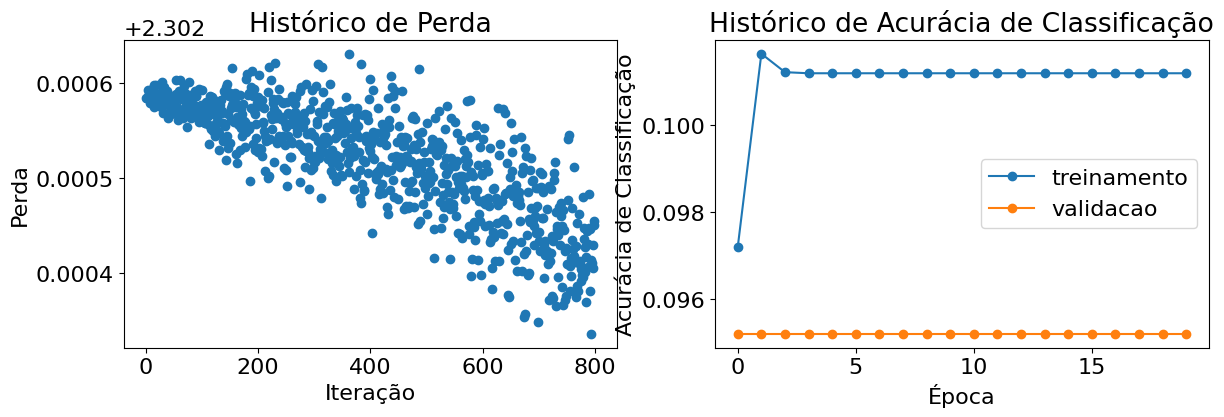

In [34]:
# Plota a função de perda e as acurácias de treinamento / validação
from t2_auxiliares import plotar_estats

plotar_estats(estats)

Visualize os pesos aprendidos para cada classe. Dependendo da sua escolha de taxa de aprendizagem e força de regularização, eles podem ou não ser agradáveis de se olhar.

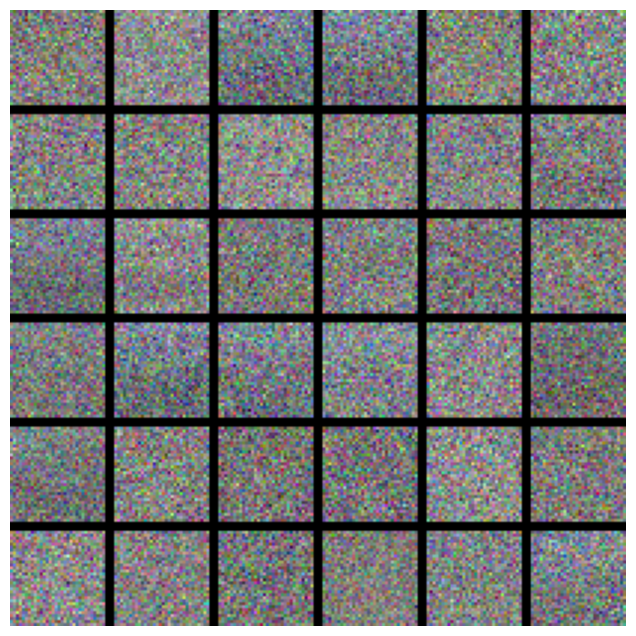

In [35]:
from t2_auxiliares import mostrar_pesos_da_rede

# visualiza os pesos da rede
mostrar_pesos_da_rede(modelo.state_dict())

# O que está errado?
Olhando para as visualizações acima, vemos que a perda está diminuindo mais ou menos linearmente, o que parece sugerir que a taxa de aprendizagem pode ser muito baixa. Além disso, não há diferença entre a acurácia de treinamento e de validação, sugerindo que o modelo que utilizamos tem baixa capacidade e que devemos aumentar seu tamanho. Por outro lado, com um modelo muito grande, esperaríamos ver mais sobreajuste, o que se manifestaria como uma diferença muito grande entre a acurácia de treinamento e de validação.

Para auxiliar nessa análise, vamos escrever uma função que encapsula toda a lógica para treinar e avaliar modelos.

In [36]:
def treinar(modelo, funcao_de_perda,
            dados_de_treinamento, dados_de_validacao,
            num_epocas, tamanho_lote,
            taxa_aprendizagem, decaimento_taxa_aprendizagem,
            reg, verbose):
  # Define um carregador de lotes para os conjuntos de dados
  lotes_de_treinamento = torch.utils.data.DataLoader(dataset=dados_de_treinamento, batch_size=tamanho_lote, shuffle=True)
  lotes_de_validacao = torch.utils.data.DataLoader(dataset=dados_de_validacao, batch_size=tamanho_lote, shuffle=False)

  # Define um otimizador SGD para atualizar os parâmetros
  otimizador = torch.optim.SGD(modelo.parameters(), lr=taxa_aprendizagem, weight_decay=reg)

  # Define um escalonador exponencial para ajustar a taxa de aprendizado
  escalonador = torch.optim.lr_scheduler.ExponentialLR(otimizador, decaimento_taxa_aprendizagem)

  # Cria a função que realiza o passo de treinamento para nosso modelo, função de perda e otimizador
  passo_de_treinamento = criar_passo_de_treinamento(modelo, funcao_de_perda, otimizador)

  # Salva estatisticas do processo de treinamento
  historico_perda = []
  historico_acc_treinamento = []
  historico_acc_validacao = []

  # para cada época
  for epoca in range(num_epocas):
    acc_treinamento = 0
    # para cada minilote de treinamento
    for i, (lote_dados, lote_rotulos) in enumerate(lotes_de_treinamento):
      # Executa um passo do treinamento e retorna a perda correspondente
      pontuacoes, perda = passo_de_treinamento(lote_dados, lote_rotulos)
      if verbose and i % 100 == 0:
        print('epoca %d / %d: perda %f' % (epoca, num_epocas, perda))
      acc_treinamento += acuracia(pontuacoes, lote_rotulos)
      historico_perda.append(perda)
    historico_acc_treinamento.append(acc_treinamento / len(lotes_de_treinamento))

    # Reduz a taxa de aprendizado
    escalonador.step()

    with torch.no_grad():
      acc_validacao = 0
      # para cada minilote de validação
      for i, (lote_dados, lote_rotulos) in enumerate(lotes_de_validacao):
        # Configura o modelo para o modo de avaliação
        modelo.eval()
        pontuacoes = modelo(lote_dados) # calcula a saída do modelo
        acc_validacao += acuracia(pontuacoes, lote_rotulos)
      historico_acc_validacao.append(acc_validacao / len(lotes_de_validacao))

  # Verifique a acurácia do conjunto de validação
  if verbose:
    print('Acurácia no conjunto de validação: %.2f%%' % float(100.0 * historico_acc_validacao[-1]))

  # Cria um dicionário com estatísticas sobre o processo de treinamento.
  estats = {
    'historico_perda': historico_perda,
    'historico_acc_treinamento': historico_acc_treinamento,
    'historico_acc_validacao': historico_acc_validacao,
  }

  return estats

## Capacidade?
Nosso modelo inicial tem desempenho muito semelhante nos conjuntos de treinamento e de validação. Isso sugere que o modelo é insuficiente e que seu desempenho pode melhorar se aumentarmos sua capacidade.

Uma maneira de aumentar a capacidade de um modelo de rede neural é aumentar o tamanho de sua camada oculta. Aqui, investigamos o efeito do aumento do tamanho da camada oculta. O desempenho (medido pela acurácia no conjunto de validação) deve aumentar à medida que o tamanho da camada oculta aumenta; no entanto, pode mostrar retornos decrescentes para tamanhos de camadas maiores.

treinamento com tamanho oculta: 2
treinamento com tamanho oculta: 8
treinamento com tamanho oculta: 32
treinamento com tamanho oculta: 128


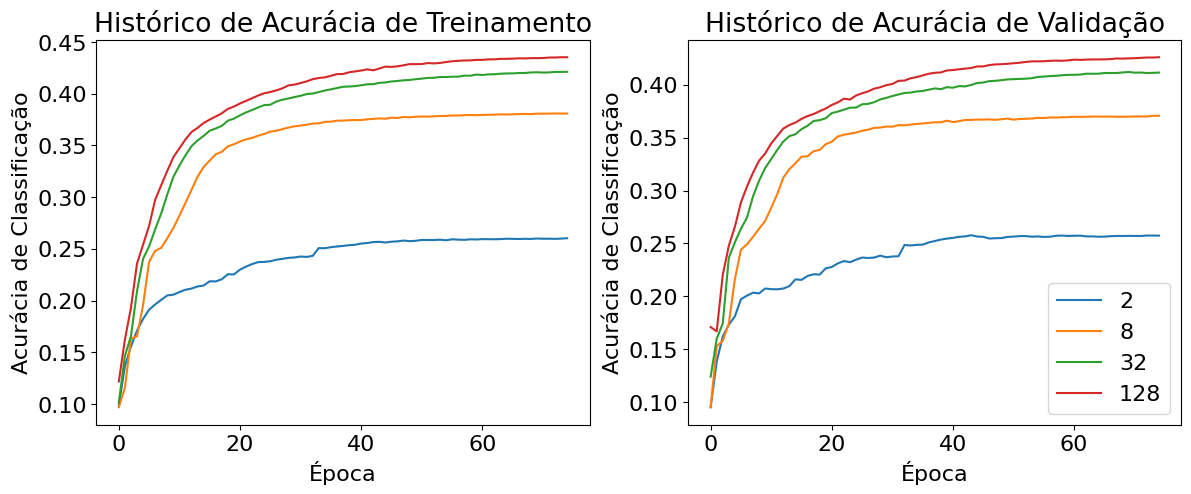

In [37]:
import pi
from t2_auxiliares import plotar_curvas_de_acuracia
from redes_totalmente_conectadas import perda_softmax
from redes_totalmente_conectadas import RedeDuasCamadas

tamanhos_oculta = [2, 8, 32, 128]
tx_aprendizagem = 0.1
reg = 0.001

dic_estats = {}
for tam_oculta in tamanhos_oculta:
  print('treinamento com tamanho oculta: {}'.format(tam_oculta))
  # ajusta a semente aleatória antes de gerar um conjunto de parâmetros
  pi.redefinir_semente(0)
  modelo = RedeDuasCamadas(3 * 32 * 32, tam_oculta, 10, device=dic_dados['X_treino'].device, dtype=dic_dados['X_treino'].dtype)
  estats = treinar(modelo, perda_softmax, dados_de_treinamento, dados_de_validacao,
             num_epocas=75, tamanho_lote=1000,
             taxa_aprendizagem=tx_aprendizagem, decaimento_taxa_aprendizagem=0.95,
             reg=reg, verbose=False)
  dic_estats[tam_oculta] = estats

plotar_curvas_de_acuracia(dic_estats)

## Regularização?
Outra possível explicação para a pequena diferença que vimos entre a acurácia de treinamento e de validação de nosso modelo é a regularização. Em particular, se o coeficiente de regularização for muito alto, o modelo pode ser incapaz de se ajustar aos dados de treinamento.

Podemos investigar o fenômeno empiricamente treinando um conjunto de modelos com forças de regularização variadas enquanto corrigimos outros hiperparâmetros.

Você deve ver que usar uma força de regularização muito alta prejudicará o desempenho do conjunto de validação do modelo:

treinamento com regularização: 0
treinamento com regularização: 1e-05
treinamento com regularização: 0.001
treinamento com regularização: 0.1


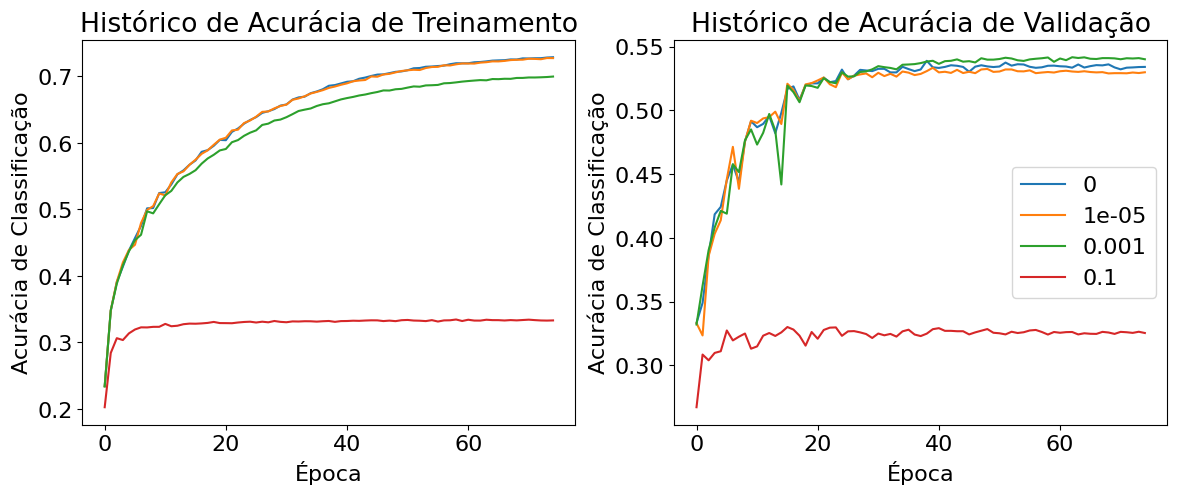

In [38]:
import pi
from t2_auxiliares import plotar_curvas_de_acuracia
from redes_totalmente_conectadas import perda_softmax
from redes_totalmente_conectadas import RedeDuasCamadas

tam_oculta = 128
tx_aprendizagem = 1.0
regs = [0, 1e-5, 1e-3, 1e-1]

dic_estats = {}
for reg in regs:
  print('treinamento com regularização: {}'.format(reg))
  # ajusta a semente aleatória antes de gerar um conjunto de parâmetros
  pi.redefinir_semente(0)
  modelo = RedeDuasCamadas(3 * 32 * 32, tam_oculta, 10, device=dic_dados['X_treino'].device, dtype=dic_dados['X_treino'].dtype)
  estats = treinar(modelo, perda_softmax, dados_de_treinamento, dados_de_validacao,
             num_epocas=75, tamanho_lote=1000,
             taxa_aprendizagem=tx_aprendizagem, decaimento_taxa_aprendizagem=0.95,
             reg=reg, verbose=False)
  dic_estats[reg] = estats

plotar_curvas_de_acuracia(dic_estats)

## Taxa de Aprendizagem?
Por último, mas não menos importante, também queremos ver o efeito da taxa de aprendizagem em relação ao desempenho.

treinamento com taxa de aprendizagem: 0.0001
treinamento com taxa de aprendizagem: 0.01
treinamento com taxa de aprendizagem: 1.0
treinamento com taxa de aprendizagem: 100.0


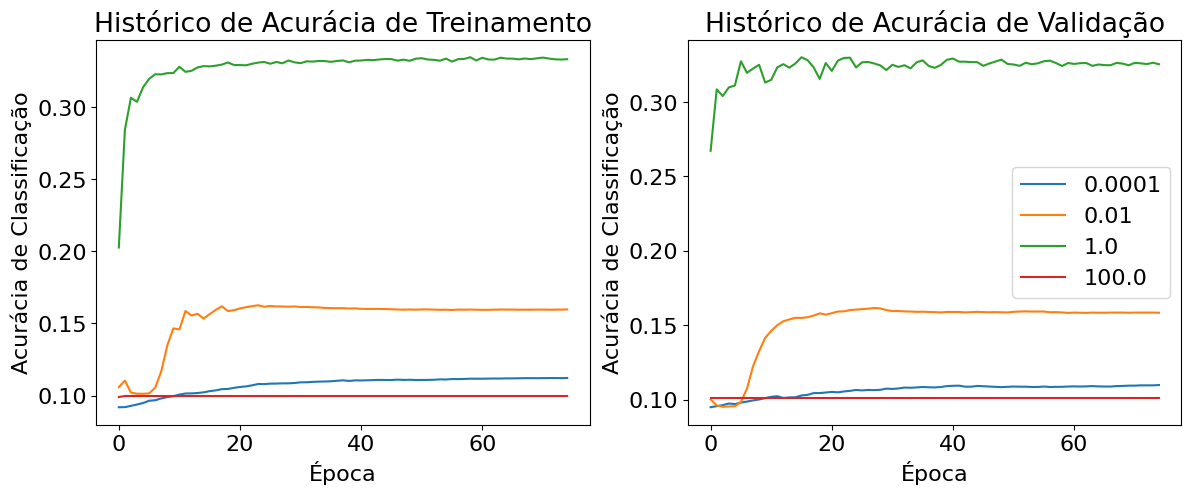

In [39]:
import pi
from t2_auxiliares import plotar_curvas_de_acuracia
from redes_totalmente_conectadas import perda_softmax
from redes_totalmente_conectadas import RedeDuasCamadas

tam_oculta = 128
taxas_aprendizagem = [1e-4, 1e-2, 1e0, 1e2]
regs = 1e-4

dic_estats = {}
for tx_aprendizagem in taxas_aprendizagem:
  print('treinamento com taxa de aprendizagem: {}'.format(tx_aprendizagem))
  # ajusta a semente aleatória antes de gerar um conjunto de parâmetros
  pi.redefinir_semente(0)
  modelo = RedeDuasCamadas(3 * 32 * 32, tam_oculta, 10, device=dic_dados['X_treino'].device, dtype=dic_dados['X_treino'].dtype)
  estats = treinar(modelo, perda_softmax, dados_de_treinamento, dados_de_validacao,
             num_epocas=75, tamanho_lote=1000,
             taxa_aprendizagem=tx_aprendizagem, decaimento_taxa_aprendizagem=0.95,
             reg=reg, verbose=False)
  dic_estats[tx_aprendizagem] = estats

plotar_curvas_de_acuracia(dic_estats)

# Ajuste seus hiperparâmetros
Agora que você já sabe como é o processo de treinamento e avaliação de modelos, daremos a você de graça uma classe chamada `Solucionador`, a qual encapsula toda a lógica necessária para treinar e avaliar modelos.

Leia `help(Solucionador)` para se familiarizar com a API. Depois de fazer isso, use uma instância `Solucionador` para treinar uma` RedeDuasCamadas` que atinja pelo menos `50%` de precisão no conjunto de validação.

In [40]:
print(help(Solucionador))

Help on class Solucionador in module pi.solucionador:

class Solucionador(builtins.object)
 |  Solucionador(modelo, funcao_de_perda, otimizador, dados, **kwargs)
 |  
 |  Um Solucionador encapsula toda a lógica necessária para treinar modelos 
 |  de classificação. O Solucionador executa a descida de gradiente estocástica 
 |  usando diferentes otimizadores.
 |  O Solucionador aceita dados de treinamento e validação e rótulos para 
 |  que possa verificar periodicamente a acurácia de classificação nos dados 
 |  de treinamento e de validação para ficar atento ao sobreajuste.
 |  Para treinar um modelo, você primeiro construirá uma instância do Solucionador, 
 |  passando o modelo, função de perda, otimizador, escalonador, conjunto de dados 
 |  e várias opções (taxa de aprendizagem, tamanho do lote, etc) para o construtor. 
 |  Em seguida, você chamará o método treinar() para executar o processo de 
 |  otimização e treinar o modelo.
 |  Depois que o método treinar() retornar, seu mode

Use a classe `Solucionador` para criar uma instância do solucionador que treina uma  `RedeDuasCamadas` para atingir pelo menos 50% de desempenho no conjunto de validação.

**Código.** Implemente `criar_instancia_solucionador` em `redes_totalmente_conectadas.py` para retornar uma instância do solucionador. Certifique-se de inicializar a instância do `Solucionador` com o dispositivo de entrada.

**Ajuste**. Ajustar os hiperparâmetros e desenvolver a intuição de como eles afetam o desempenho final é uma grande parte do uso de Redes Neurais, portanto, queremos que você pratique bastante. Você deve experimentar diferentes valores dos vários hiperparâmetros, incluindo tamanho da camada oculta, taxa de aprendizagem, número de épocas de treinamento e força de regularização. Você também pode considerar o fator de decaimento da taxa de aprendizagem, mas deve ser capaz de obter um bom desempenho usando o valor padrão.

**Gráficos**. Para orientar sua pesquisa de hiperparâmetros, você pode considerar fazer gráficos auxiliares de desempenho de treinamento e de validação como acima, ou plotar os resultados decorrentes de diferentes combinações de hiperparâmetros. Você deve se sentir à vontade para representar graficamente quaisquer resultados auxiliares necessários para encontrar uma boa rede, mas não será exigido nenhum gráfico específico de você.

**Resultados aproximados**. Para obter a nota máxima da tarefa, você deve atingir uma acurácia de classificação acima de 50% no conjunto de validação.

In [69]:
from redes_totalmente_conectadas import criar_instancia_solucionador

redefinir_semente(0)

# Cria uma instância do solucionador que alcance 50% de desempenho no conjunto de validação
solucionador = criar_instancia_solucionador(dic_dados=dic_dados, dtype=torch.float32, device='cuda')
estats = solucionador.treinar()

(Tempo 0.01 segundos; Iteração 1 / 4000) perda: 2.302611
(Época 0 / 10) acurácia de treinamento: 10.30%; acurácia de validação: 9.80%
(Tempo 0.18 segundos; Iteração 11 / 4000) perda: 2.301571
(Tempo 0.20 segundos; Iteração 21 / 4000) perda: 2.302373
(Tempo 0.23 segundos; Iteração 31 / 4000) perda: 2.299770
(Tempo 0.26 segundos; Iteração 41 / 4000) perda: 2.300058
(Tempo 0.28 segundos; Iteração 51 / 4000) perda: 2.297039
(Tempo 0.30 segundos; Iteração 61 / 4000) perda: 2.285754
(Tempo 0.33 segundos; Iteração 71 / 4000) perda: 2.266736
(Tempo 0.35 segundos; Iteração 81 / 4000) perda: 2.209369
(Tempo 0.38 segundos; Iteração 91 / 4000) perda: 2.168424
(Tempo 0.40 segundos; Iteração 101 / 4000) perda: 2.138360
(Tempo 0.43 segundos; Iteração 111 / 4000) perda: 2.143022
(Tempo 0.45 segundos; Iteração 121 / 4000) perda: 2.108028
(Tempo 0.48 segundos; Iteração 131 / 4000) perda: 2.089639
(Tempo 0.50 segundos; Iteração 141 / 4000) perda: 1.995395
(Tempo 0.53 segundos; Iteração 151 / 4000) perda:

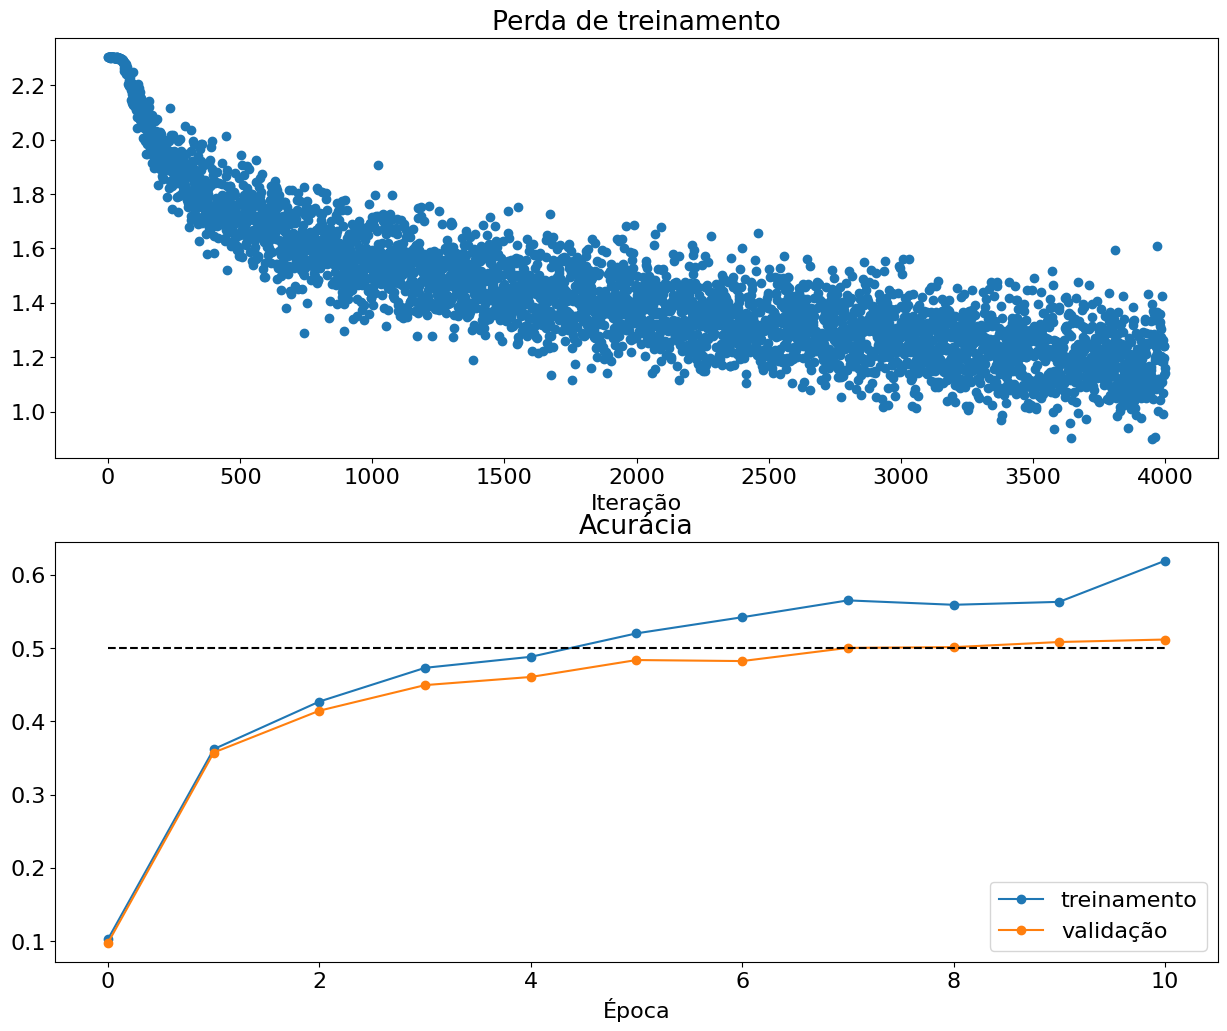

In [70]:
# Execute esta célula para visualizar a perda de treinamento e a acurácia de treinamento / validação
plt.subplot(2, 1, 1)
plt.title('Perda de treinamento')
plt.plot(solucionador.historico_perda, 'o')
plt.xlabel('Iteração')

plt.subplot(2, 1, 2)
plt.title('Acurácia')
plt.plot(solucionador.historico_acc_treinamento, '-o', label='treinamento')
plt.plot(solucionador.historico_acc_validacao, '-o', label='validação')
plt.plot([0.5] * len(solucionador.historico_acc_validacao), 'k--')
plt.xlabel('Época')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

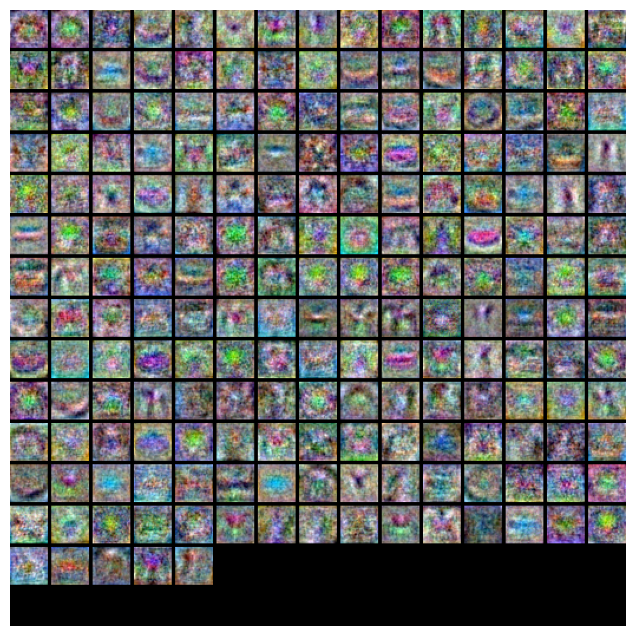

In [71]:
from t2_auxiliares import mostrar_pesos_da_rede
# visualiza os pesos da rede
mostrar_pesos_da_rede(solucionador.modelo.state_dict())

# Salvando e carregando modelos
Se você estiver satisfeito com o desempenho do modelo, execute a seguinte célula para salvá-lo.
Também iremos recarregar o modelo e executá-lo na validação para verificar se tem os pesos corretos.

Ao salvar um modelo para inferência, é necessário apenas salvar os parâmetros aprendidos do modelo treinado. Salvar o `state_dict()` do modelo com a função [`torch.save()`](https://pytorch.org/docs/stable/generated/torch.save.html) dará a você mais flexibilidade para restaurar o modelo mais tarde com a função [`torch.load()`](https://pytorch.org/docs/stable/generated/torch.load.html), por isso, é o método recomendado para salvar modelos.

Uma convenção comum do PyTorch é salvar modelos usando uma extensão de arquivo `.pt` ou `.pth`.

Lembre-se de que você deve chamar o método `eval()` para definir as camadas de descarte e normalização de lote para o modo de inferência antes de realizar previsões. Deixar de fazer isso produzirá resultados inconsistentes.

In [72]:
# Salva o melhor modelo
path = os.path.join(GOOGLE_DRIVE_PATH, 'melhor_rede_duas_camadas.pt')
torch.save(solucionador.modelo.state_dict(), path)

# Cria uma nova instância
from redes_totalmente_conectadas import criar_instancia_solucionador
redefinir_semente(0)

solucionador = criar_instancia_solucionador(dic_dados=dic_dados, dtype=torch.float32, device='cuda')

# Carrega o modelo
solucionador.modelo.load_state_dict(torch.load(path))

# Avalia no conjunto de validação
acuracia = solucionador.verificar_acuracia(solucionador.validacao)
print('A acurácia do modelo salvo na validação é: %.2f%%' % float(100.0 * acuracia))


A acurácia do modelo salvo na validação é: 51.16%


# Rede multicamadas
Em seguida, você implementará uma rede totalmente conectada com um número arbitrário de camadas ocultas.

Leia a classe `RedeTotalmenteConectada` em` redes_totalmente_conectadas.py`. Implemente a inicialização e o passo para frente. No momento, não se preocupe em implementar o descarte; vamos adicionar esse recurso em breve.

Como uma verificação, certifique-se de sobreajustar um pequeno conjunto de dados de 50 imagens. Primeiro, tentaremos uma rede de três camadas com 100 unidades em cada camada oculta. Na célula a seguir, ajuste a **taxa de aprendizagem** e a **escala de inicialização de peso** para sobreajustar e alcançar 100% de acurácia de treinamento em 20 épocas.

(Tempo 0.00 segundos; Iteração 1 / 40) perda: 2.430351
(Época 0 / 20) acurácia de treinamento: 40.00%; acurácia de validação: 10.39%
(Época 1 / 20) acurácia de treinamento: 42.00%; acurácia de validação: 13.71%
(Época 2 / 20) acurácia de treinamento: 40.00%; acurácia de validação: 10.97%
(Época 3 / 20) acurácia de treinamento: 62.00%; acurácia de validação: 15.21%
(Época 4 / 20) acurácia de treinamento: 90.00%; acurácia de validação: 16.97%
(Época 5 / 20) acurácia de treinamento: 96.00%; acurácia de validação: 17.17%
(Tempo 0.71 segundos; Iteração 11 / 40) perda: 0.319027
(Época 6 / 20) acurácia de treinamento: 92.00%; acurácia de validação: 17.45%
(Época 7 / 20) acurácia de treinamento: 100.00%; acurácia de validação: 16.54%
(Época 8 / 20) acurácia de treinamento: 100.00%; acurácia de validação: 17.26%
(Época 9 / 20) acurácia de treinamento: 100.00%; acurácia de validação: 17.69%
(Época 10 / 20) acurácia de treinamento: 100.00%; acurácia de validação: 17.70%
(Tempo 1.30 segundos; Iter

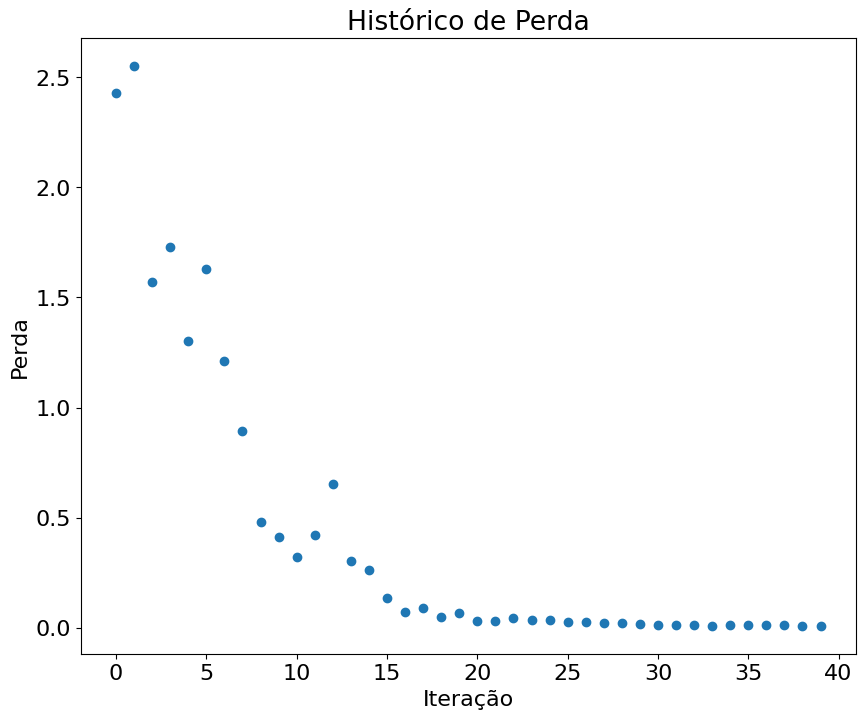

In [45]:
from redes_totalmente_conectadas import perda_softmax
from redes_totalmente_conectadas import ConjuntoDeDados
from redes_totalmente_conectadas import RedeTotalmenteConectada
from redes_totalmente_conectadas import retorna_params_rede_tres_camadas

# TODO: Use uma rede de três camadas para sobreajustar 50 exemplos de treinamento
# ajustando apenas a taxa de aprendizado e escala de inicialização de peso.
redefinir_semente(0)

num_treino = 50
dados_pequeno = {
  'treinamento': ConjuntoDeDados(dic_dados['X_treino'][:num_treino],
                                 dic_dados['y_treino'][:num_treino]),
  'validacao': ConjuntoDeDados(dic_dados['X_val'], dic_dados['y_val']),
}

# Atualize os parâmetros em retorna_params_rede_tres_camadas
escala_peso, taxa_aprendizagem = retorna_params_rede_tres_camadas()

modelo = RedeTotalmenteConectada([100, 100], escala_peso=escala_peso)
otimizador = torch.optim.SGD(modelo.parameters(), lr=taxa_aprendizagem)
solucionador = Solucionador(modelo, perda_softmax, otimizador, dados_pequeno,
                  imprime_cada=10, num_epocas=20, tamanho_lote=25,
                  device='cuda'
               )
stats = solucionador.treinar()

plt.plot(solucionador.historico_perda, 'o')
plt.title('Histórico de Perda')
plt.xlabel('Iteração')
plt.ylabel('Perda')
plt.show()

Agora tente usar uma rede de cinco camadas com 100 unidades em cada camada para ajustar 50 exemplos de treinamento. Novamente, você terá que ajustar a taxa de aprendizado e a escala de inicialização de peso, mas deverá ser capaz de atingir 100% de acurácia de treinamento em 20 épocas.

(Tempo 0.00 segundos; Iteração 1 / 40) perda: 2.326926
(Época 0 / 20) acurácia de treinamento: 16.00%; acurácia de validação: 9.19%
(Época 1 / 20) acurácia de treinamento: 26.00%; acurácia de validação: 10.80%
(Época 2 / 20) acurácia de treinamento: 50.00%; acurácia de validação: 11.94%
(Época 3 / 20) acurácia de treinamento: 30.00%; acurácia de validação: 9.99%
(Época 4 / 20) acurácia de treinamento: 48.00%; acurácia de validação: 13.84%
(Época 5 / 20) acurácia de treinamento: 54.00%; acurácia de validação: 13.45%
(Tempo 0.78 segundos; Iteração 11 / 40) perda: 1.398803
(Época 6 / 20) acurácia de treinamento: 68.00%; acurácia de validação: 15.61%
(Época 7 / 20) acurácia de treinamento: 72.00%; acurácia de validação: 18.12%
(Época 8 / 20) acurácia de treinamento: 80.00%; acurácia de validação: 18.03%
(Época 9 / 20) acurácia de treinamento: 88.00%; acurácia de validação: 17.40%
(Época 10 / 20) acurácia de treinamento: 92.00%; acurácia de validação: 18.43%
(Tempo 1.42 segundos; Iteração 2

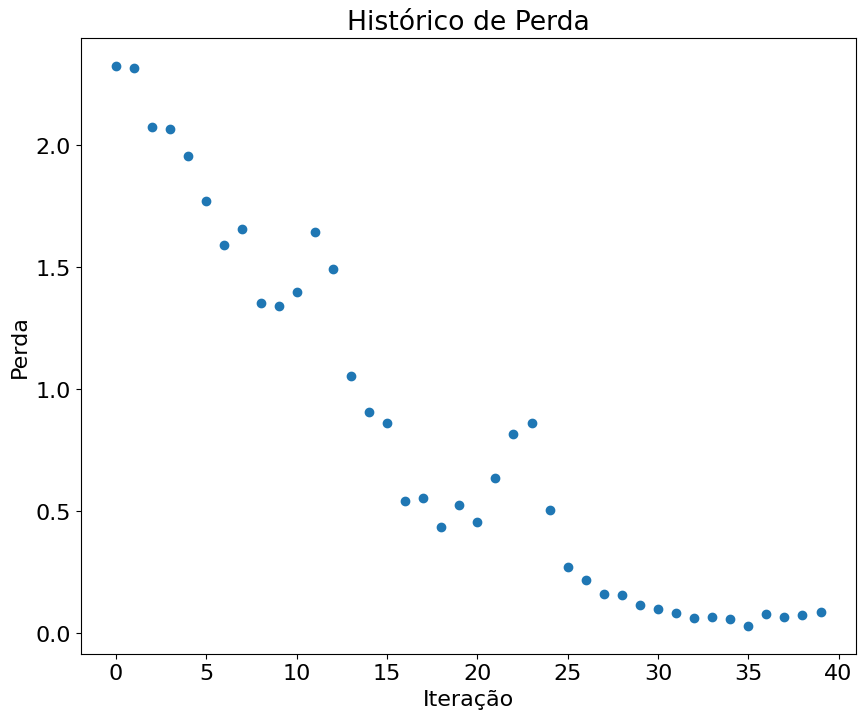

In [63]:
from redes_totalmente_conectadas import perda_softmax
from redes_totalmente_conectadas import ConjuntoDeDados
from redes_totalmente_conectadas import RedeTotalmenteConectada
from redes_totalmente_conectadas import retorna_params_rede_cinco_camadas

# TODO: Use uma rede de cinco camadas para sobreajustar 50 exemplos de treinamento
# ajustando apenas a taxa de aprendizado e escala de inicialização de peso.
redefinir_semente(0)

num_treino = 50
dados_pequeno = {
  'treinamento': ConjuntoDeDados(dic_dados['X_treino'][:num_treino],
                                 dic_dados['y_treino'][:num_treino]),
  'validacao': ConjuntoDeDados(dic_dados['X_val'], dic_dados['y_val']),
}

# Atualize os parâmetros em retorna_params_rede_cinco_camadas
escala_peso, taxa_aprendizagem = retorna_params_rede_cinco_camadas()

modelo = RedeTotalmenteConectada([100, 100, 100, 100], escala_peso=escala_peso)
otimizador = torch.optim.SGD(modelo.parameters(), lr=taxa_aprendizagem)
solucionador = Solucionador(modelo, perda_softmax, otimizador, dados_pequeno,
                  imprime_cada=10, num_epocas=20, tamanho_lote=25,
                  device='cuda'
               )
# Ajuste retornar_melhores_parametros para permitir que os parâmetros finais
# sejam salvos, em vez dos melhores pesos no conjunto de validação.
estats = solucionador.treinar(retornar_melhores_parametros=False)

plt.plot(solucionador.historico_perda, 'o')
plt.title('Histórico de Perda')
plt.xlabel('Iteração')
plt.ylabel('Perda')
plt.show()

Se você está satisfeito com o desempenho do seu modelo, salve o modelo sobreajustado. Apenas para confirmação, avaliaremos ele novamente no conjunto de treinamento para verificar se os pesos salvos têm o desempenho correto.

In [64]:
# Salva o melhor modelo
path = os.path.join(GOOGLE_DRIVE_PATH, 'melhor_sobreajuste_rede_cinco_camadas.pt')
torch.save(solucionador.modelo.state_dict(), path)

# Cria uma nova instância
modelo = RedeTotalmenteConectada([100, 100, 100, 100])
solucionador = Solucionador(modelo, perda_softmax, otimizador, dados_pequeno,
                  imprime_cada=10, num_epocas=20, tamanho_lote=25,
                  device='cuda'
               )

# Carrega o modelo
solucionador.modelo.load_state_dict(torch.load(path))

# Avalia no subconjunto de treinamento
acuracia = solucionador.verificar_acuracia(solucionador.treinamento)
print('A acurácia do modelo salvo no subconjunto de treinamento é: %.2f%%' % float(100.0 * acuracia))

A acurácia do modelo salvo no subconjunto de treinamento é: 100.00%


# Regras de atualização
Até agora, usamos a descida de gradiente estocástica (SGD) como nossa regra de atualização. Regras de atualização mais sofisticadas podem facilitar o treinamento de redes profundas. Vamos avaliar algumas das regras de atualização mais comumente usadas e compará-las com o SGD.

## SGD + Momentum
A descida de gradiente estocástica com momentum é uma regra de atualização amplamente usada que tende a fazer as redes profundas convergirem mais rápido do que a descida de gradiente estocástica. Consulte a regra de atualização do Momentum em http://cs231n.github.io/neural-networks-3/#sgd para obter mais informações.

O PyTorch implementa várias regras de atualização de primeira ordem que são comumente usadas para treinar redes neurais. Cada regra de atualização aceita pesos atuais e o gradiente da perda em relação a esses pesos e produz o próximo conjunto de pesos.

Execute o seguinte para treinar uma rede de seis camadas com SGD e SGD+momentum. Você deve ver a regra de atualização de SGD+momentum convergir mais rápido.

executando com  sgd
(Tempo 0.00 segundos; Iteração 1 / 200) perda: 2.302756
(Época 0 / 5) acurácia de treinamento: 10.60%; acurácia de validação: 10.18%
(Época 1 / 5) acurácia de treinamento: 11.60%; acurácia de validação: 10.00%
(Época 2 / 5) acurácia de treinamento: 11.50%; acurácia de validação: 9.97%
(Época 3 / 5) acurácia de treinamento: 11.50%; acurácia de validação: 10.01%
(Época 4 / 5) acurácia de treinamento: 13.30%; acurácia de validação: 11.28%
(Época 5 / 5) acurácia de treinamento: 10.40%; acurácia de validação: 10.00%

executando com  sgd+momentum
(Tempo 0.01 segundos; Iteração 1 / 200) perda: 2.302756
(Época 0 / 5) acurácia de treinamento: 10.60%; acurácia de validação: 10.18%
(Época 1 / 5) acurácia de treinamento: 11.40%; acurácia de validação: 9.97%
(Época 2 / 5) acurácia de treinamento: 11.50%; acurácia de validação: 9.97%
(Época 3 / 5) acurácia de treinamento: 16.40%; acurácia de validação: 16.71%
(Época 4 / 5) acurácia de treinamento: 23.00%; acurácia de validação: 2

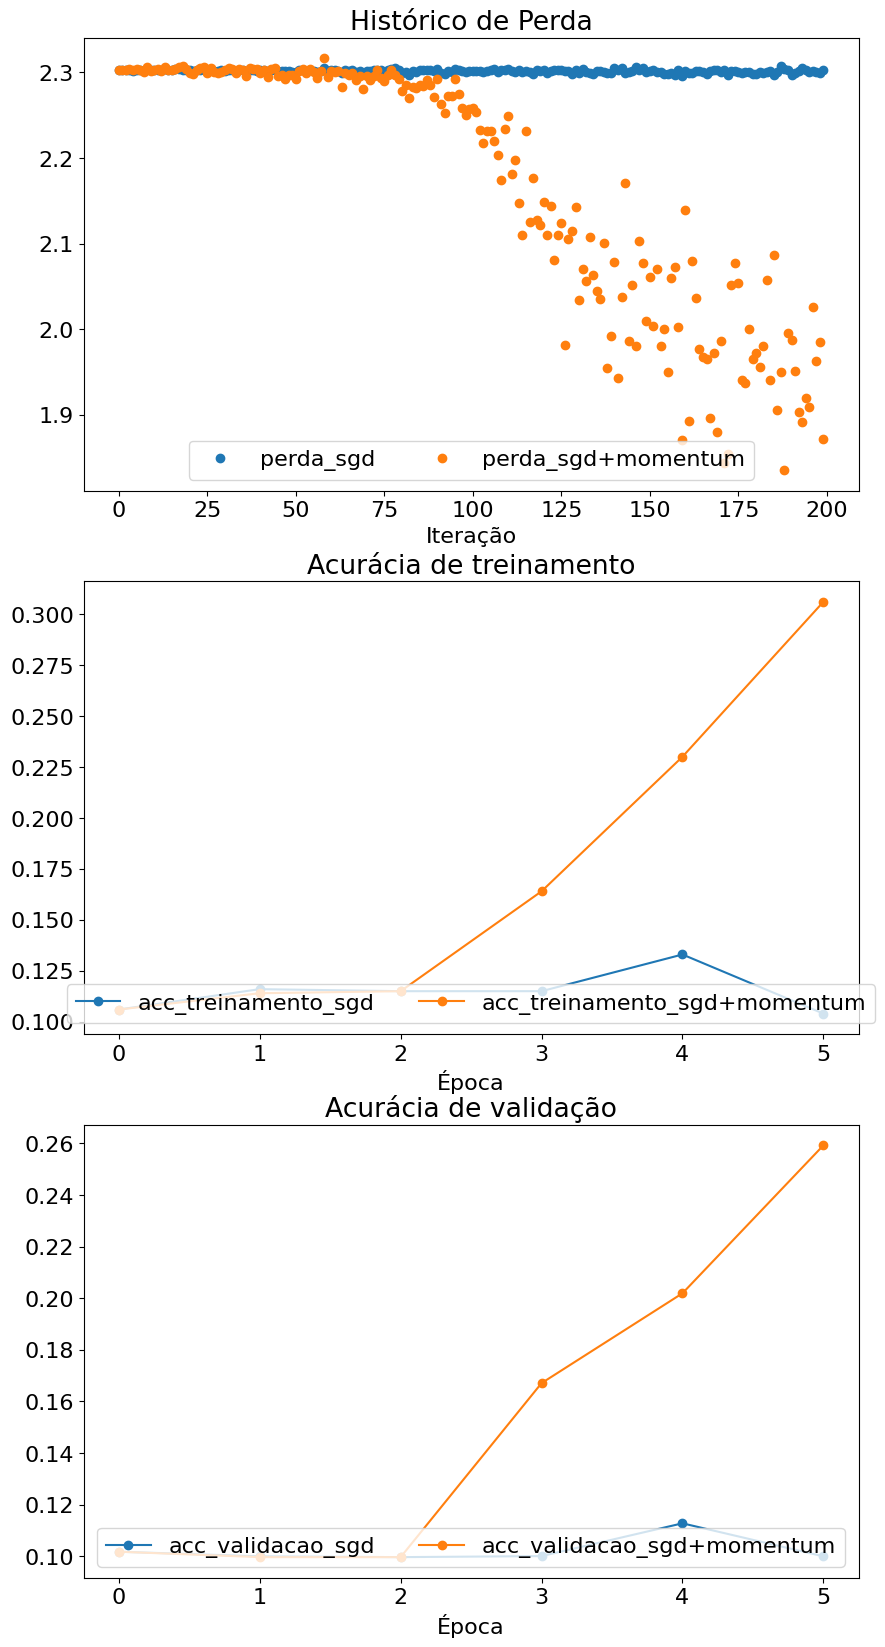

In [65]:
from redes_totalmente_conectadas import RedeTotalmenteConectada

# Treina duas redes idênticas, uma com SGD e outra com SGD+momentum
redefinir_semente(0)

num_treino = 4000
dados_pequeno = {
  'treinamento': ConjuntoDeDados(dic_dados['X_treino'][:num_treino],
                                 dic_dados['y_treino'][:num_treino]),
  'validacao': ConjuntoDeDados(dic_dados['X_val'], dic_dados['y_val']),
}

solucionadores = {}

for nome_regra_atualizacao, momentum in [('sgd', 0), ('sgd+momentum', 0.9)]:
  print('executando com ', nome_regra_atualizacao)

  modelo = RedeTotalmenteConectada([100, 100, 100, 100, 100], escala_peso=5e-2)
  otimizador = torch.optim.SGD(modelo.parameters(), lr=5e-2, momentum=momentum)

  solucionador = Solucionador(modelo, perda_softmax, otimizador, dados_pequeno,
                   imprime_cada=1000, num_epocas=5, tamanho_lote=100,
                   device='cuda'
                 )
  solucionadores[nome_regra_atualizacao] = solucionador
  solucionador.treinar()
  print()

plt.subplot(3, 1, 1)
plt.title('Histórico de Perda')
plt.xlabel('Iteração')
for regra_atualizacao, solucionador in solucionadores.items():
  plt.plot(solucionador.historico_perda, 'o', label="perda_%s" % regra_atualizacao)
plt.legend(loc='lower center', ncol=4)

plt.subplot(3, 1, 2)
plt.title('Acurácia de treinamento')
plt.xlabel('Época')
for regra_atualizacao, solucionador in solucionadores.items():
  plt.plot(solucionador.historico_acc_treinamento, '-o', label="acc_treinamento_%s" % regra_atualizacao)
plt.legend(loc='lower center', ncol=4)


plt.subplot(3, 1, 3)
plt.title('Acurácia de validação')
plt.xlabel('Época')
for regra_atualizacao, solucionador in solucionadores.items():
  plt.plot(solucionador.historico_acc_validacao, '-o', label="acc_validacao_%s" % regra_atualizacao)
plt.legend(loc='lower center', ncol=4)

plt.gcf().set_size_inches(10, 20)
plt.show()

## RMSprop
RMSprop [1] é uma regra de atualização que define taxas de aprendizado por parâmetro usando uma média de execução dos segundos momentos de gradientes.

[1] Tijmen Tieleman e Geoffrey Hinton. "Aula 6.5-rmsprop: Divida o gradiente por uma média contínua de sua magnitude recente." COURSERA: Redes Neurais para Aprendizado de Máquina 4 (2012).

## Adam
Adam [2] estende o RMSprop com um cache de gradiente de primeira ordem semelhante ao momentum, e um mecanismo de correção de viés para evitar grandes etapas no início da otimização. Adam é uma das regras de atualização mais comumente usadas na prática para treinar redes neurais profundas.

[2] Diederik Kingma e Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

Execute a célula seguinte para comparar redes profundas treinadas usando as regras de atualização RMSProp e Adam:

executando com  adam
(Tempo 0.00 segundos; Iteração 1 / 200) perda: 2.302756
(Época 0 / 5) acurácia de treinamento: 10.60%; acurácia de validação: 10.30%
(Época 1 / 5) acurácia de treinamento: 24.60%; acurácia de validação: 22.61%
(Época 2 / 5) acurácia de treinamento: 28.90%; acurácia de validação: 27.41%
(Época 3 / 5) acurácia de treinamento: 33.20%; acurácia de validação: 30.23%
(Época 4 / 5) acurácia de treinamento: 41.40%; acurácia de validação: 32.23%
(Época 5 / 5) acurácia de treinamento: 44.60%; acurácia de validação: 34.67%

executando com  rmsprop
(Tempo 0.01 segundos; Iteração 1 / 200) perda: 2.302756
(Época 0 / 5) acurácia de treinamento: 10.60%; acurácia de validação: 10.31%
(Época 1 / 5) acurácia de treinamento: 23.70%; acurácia de validação: 21.14%
(Época 2 / 5) acurácia de treinamento: 25.10%; acurácia de validação: 23.57%
(Época 3 / 5) acurácia de treinamento: 27.20%; acurácia de validação: 25.05%
(Época 4 / 5) acurácia de treinamento: 30.20%; acurácia de validação: 26

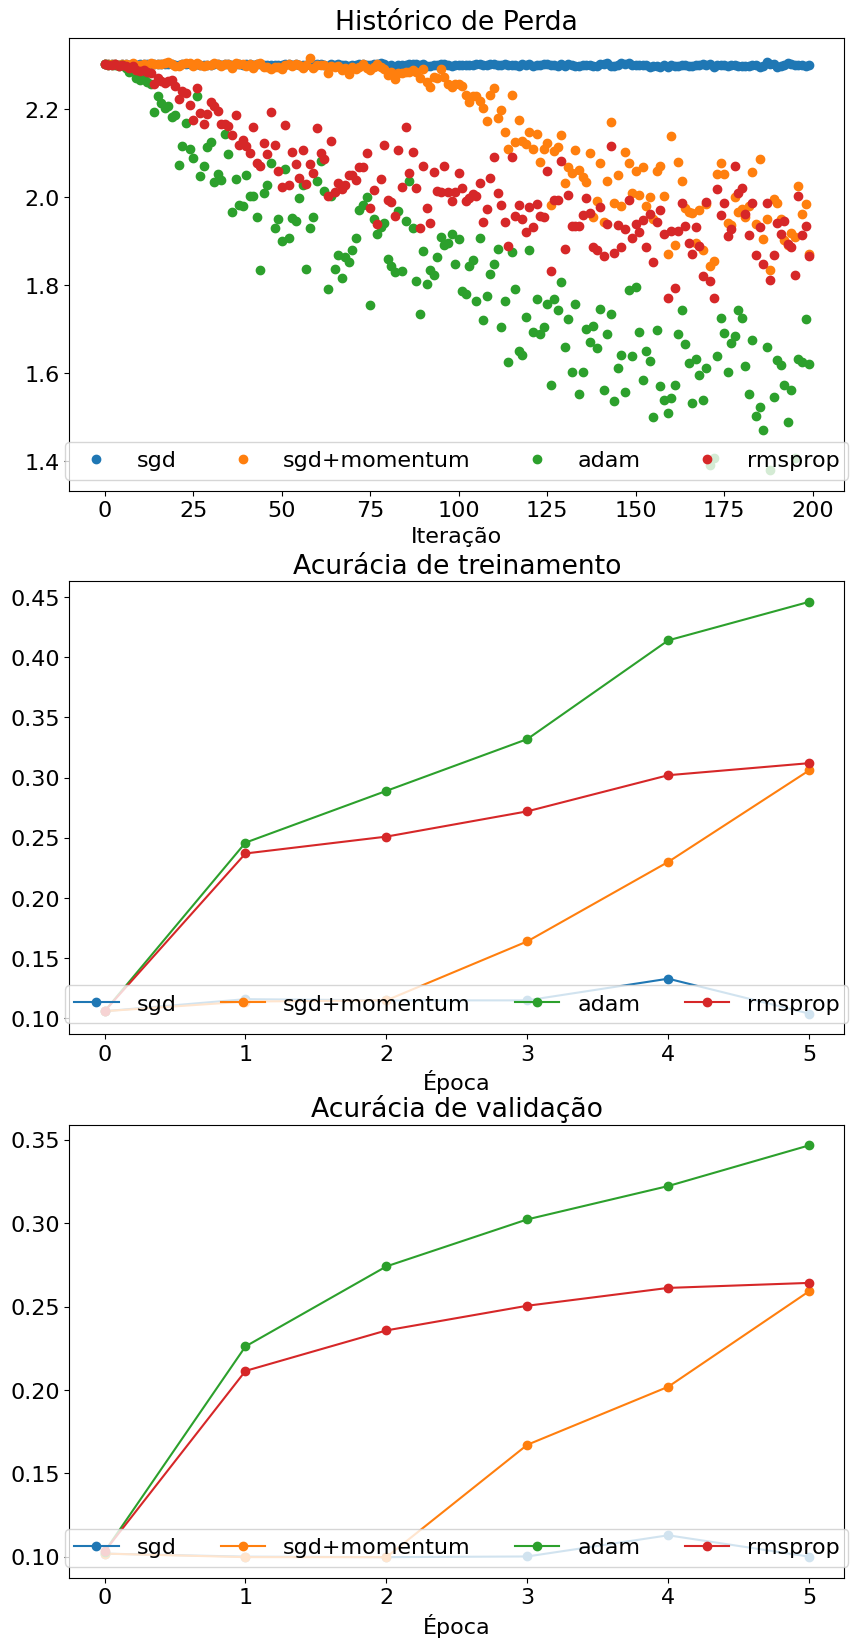

In [66]:
from redes_totalmente_conectadas import RedeTotalmenteConectada

for nome_regra_atualizacao, fn_regra_atualizacao, taxa_aprendizagem in [('adam', torch.optim.Adam, 1e-3), ('rmsprop', torch.optim.RMSprop, 1e-4)]:
  print('executando com ', nome_regra_atualizacao)

  modelo = RedeTotalmenteConectada([100, 100, 100, 100, 100], escala_peso=5e-2)
  otimizador = fn_regra_atualizacao(modelo.parameters(), lr=taxa_aprendizagem)

  solucionador = Solucionador(modelo, perda_softmax, otimizador, dados_pequeno,
                   imprime_cada=1000, num_epocas=5, tamanho_lote=100,
                   device='cuda'
                 )
  solucionadores[nome_regra_atualizacao] = solucionador
  solucionador.treinar()
  print()

plt.subplot(3, 1, 1)
plt.title('Histórico de Perda')
plt.xlabel('Iteração')
for regra_atualizacao, solucionador in solucionadores.items():
  plt.plot(solucionador.historico_perda, 'o', label=regra_atualizacao)
plt.legend(loc='lower center', ncol=4)

plt.subplot(3, 1, 2)
plt.title('Acurácia de treinamento')
plt.xlabel('Época')
for regra_atualizacao, solucionador in solucionadores.items():
  plt.plot(solucionador.historico_acc_treinamento, '-o', label=regra_atualizacao)
plt.legend(loc='lower center', ncol=4)


plt.subplot(3, 1, 3)
plt.title('Acurácia de validação')
plt.xlabel('Época')
for regra_atualizacao, solucionador in solucionadores.items():
  plt.plot(solucionador.historico_acc_validacao, '-o', label=regra_atualizacao)
plt.legend(loc='lower center', ncol=4)

plt.gcf().set_size_inches(10, 20)
plt.show()

# Redes totalmente conectadas com descarte
Descarte [1] é uma técnica para regularizar redes neurais ao configurar aleatoriamente algumas ativações de saída para zero durante o passo para frente. No Pytorch, essa técnica é implementada pela classe [`torch.nn.Dropout`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html).

[1] [Geoffrey E. Hinton et al, "Improving neural networks by Avoiding Co-Adaptation of feature detectectors", arXiv 2012](https://arxiv.org/abs/1207.0580)

Modifique sua implementação de [`RedeTotalmenteConectada`](#scrollTo=eNyFLT1We1DI) para usar descarte. Especificamente, se o construtor da rede recebe um valor diferente de 0 para o parâmetro `descarte`, então a rede deve adicionar uma camada de descarte imediatamente após cada ativação ReLU.

Para ter uma ideia de como o dropout pode regularizar uma rede neural, treinaremos três redes de duas camadas diferentes:

1. Camada oculta com 256 unidades, descarte = 0
2. Camada oculta com 512 unidades, descarte = 0
3. Camada oculta com 512 unidades, descarte = 0,5

Em seguida, visualizaremos as acurácias de treinamento e validação dessas três redes.

In [67]:
from redes_totalmente_conectadas import perda_softmax
from redes_totalmente_conectadas import ConjuntoDeDados
from redes_totalmente_conectadas import RedeTotalmenteConectada

# Treina duas redes idênticas, uma com descarte e outra sem
redefinir_semente(0)
num_treino = 20000
dados_pequeno = {
  'treinamento': ConjuntoDeDados(dic_dados['X_treino'][:num_treino],
                                 dic_dados['y_treino'][:num_treino]),
  'validacao': ConjuntoDeDados(dic_dados['X_val'], dic_dados['y_val']),
}

solucionadores = {}
escolhas_descarte = [0, 0, 0.5]
escolhas_largura = [256, 512, 512]
for descarte, largura in zip(escolhas_descarte, escolhas_largura):
# for descarte in escolhas_descarte:
  modelo = RedeTotalmenteConectada([largura], descarte=descarte)
  otimizador = torch.optim.Adam(modelo.parameters(), lr=5e-3)
  print('Treina um modelo com descarte=%.2f e largura=%d' % (descarte, largura))

  solucionador = Solucionador(modelo, perda_softmax, otimizador, dados_pequeno,
                   imprime_cada=100000, imprime_acc_cada=10,
                   num_epocas=100, tamanho_lote=512,
                   device='cuda'
                 )

  solucionador.treinar()
  solucionadores[(descarte, largura)] = solucionador
  print()

Treina um modelo com descarte=0.00 e largura=256
(Tempo 0.01 segundos; Iteração 1 / 4000) perda: 2.304007
(Época 0 / 100) acurácia de treinamento: 22.80%; acurácia de validação: 23.29%
(Época 10 / 100) acurácia de treinamento: 75.00%; acurácia de validação: 46.83%
(Época 20 / 100) acurácia de treinamento: 85.30%; acurácia de validação: 46.84%
(Época 30 / 100) acurácia de treinamento: 94.70%; acurácia de validação: 46.83%
(Época 40 / 100) acurácia de treinamento: 92.90%; acurácia de validação: 45.79%
(Época 50 / 100) acurácia de treinamento: 99.20%; acurácia de validação: 47.72%
(Época 60 / 100) acurácia de treinamento: 94.90%; acurácia de validação: 45.56%
(Época 70 / 100) acurácia de treinamento: 99.40%; acurácia de validação: 46.79%
(Época 80 / 100) acurácia de treinamento: 100.00%; acurácia de validação: 47.74%
(Época 90 / 100) acurácia de treinamento: 100.00%; acurácia de validação: 47.91%
(Época 100 / 100) acurácia de treinamento: 100.00%; acurácia de validação: 47.94%

Treina um 

Se tudo funcionou conforme o esperado, você verá que a rede com descarte tem menores acurácias de treinamento do que as redes sem descarte, mas que atinge maiores acurácias de validação.

Você também deve ver que uma rede com largura 512 e descarte 0,5 obtém maior acurácia de validação do que uma rede com largura 256 e nenhum descarte. Isso demonstra que reduzir o tamanho do modelo geralmente não é uma estratégia de regularização eficaz - geralmente é melhor usar um modelo maior com regularização explícita.

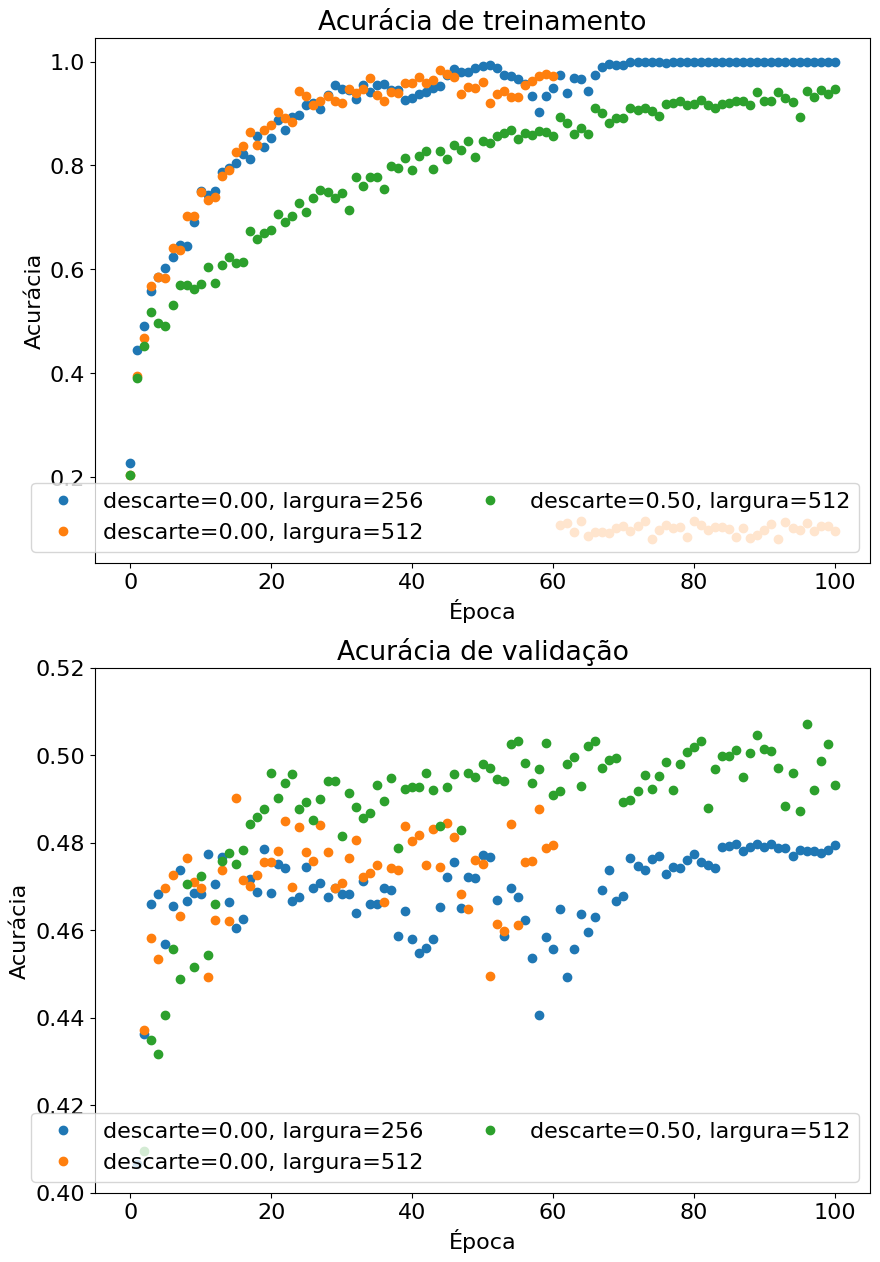

In [68]:
plt.subplot(2, 1, 1)
for (descarte, largura), solucionador in solucionadores.items():
  acc_treinamento = solucionador.historico_acc_treinamento
  label = 'descarte=%.2f, largura=%d' % (descarte, largura)
  plt.plot(acc_treinamento, 'o', label=label)
plt.title('Acurácia de treinamento')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend(ncol=2, loc='lower right')

plt.subplot(2, 1, 2)
for (descarte, largura), solucionador in solucionadores.items():
  acc_validacao = solucionador.historico_acc_validacao
  label = 'descarte=%.2f, largura=%d' % (descarte, largura)
  plt.plot(acc_validacao, 'o', label=label)
plt.ylim(0.4, 0.52)
plt.title('Acurácia de validação')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(10, 15)
plt.show()